In [325]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
import requests
import bs4
from bs4 import BeautifulSoup
import time
from collections import Counter
from tqdm import tqdm
from sklearn import preprocessing

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('dark_background')
pd.set_option('display.max_rows', 100)

In [326]:
#break up the processed code to take the fighter information that they have kindly scraped
#We can use our own data at a later date

In [327]:
## Import Data from Kaggle/Scrape

#data = pd.read_csv('UFC data/data.csv')
#preprocessed_data = pd.read_csv('UFC data/preprocessed_data.csv')

raw_fighter_details = pd.read_csv('UFC data/raw_fighter_details.csv')
raw_total_fight_data = pd.read_csv('UFC data/raw_total_fight_data.csv', sep=';')

#data = data[data['weight_class'] == 'Middleweight']
#data.head(5)

In [328]:
## Process raw fighter details
## Convert columns to metric system and dtype float
## Create function for each metric and apply it to the columm

## we dont want their overall stats so we take only the first 6 columns
static_stats = raw_fighter_details.iloc[:,:6]
static_stats.Height.value_counts()
import math

def height_convert(h):
    try:
        float(h)
        #print('cool')
    except:
        height = re.findall('\d+',h)
        feet = int(height[0])
        inches = int(height[1])
        tot_inches = feet*12 + inches
        meters = tot_inches * 0.0254
        return round(meters,2) 

def inch_convert(h):
    try:
        float(h)
        #print('cool')
    except:
        height = re.findall('\d+',h)
        #feet = int(height[0])
        inches = int(height[0])
        #tot_inches = feet*12 + inches
        meters = inches * 0.0254
        return round(meters,2) 

def weight_convert(h):
    try:
        float(h)
        #print('cool')
    except:
        weight = re.findall('\d+',h)
        weight = int(weight[0])* 0.453592
        return round(weight,2) 
    
    
#inch_convert("11")


static_stats['Height'] = static_stats.Height.apply(height_convert)
static_stats['Reach'] = static_stats.Reach.apply(inch_convert)
static_stats['Weight'] = static_stats.Weight.apply(weight_convert)
static_stats['DOB'] = static_stats.DOB.apply(lambda x: pd.to_datetime(x))

<AxesSubplot:xlabel='Height', ylabel='Reach'>

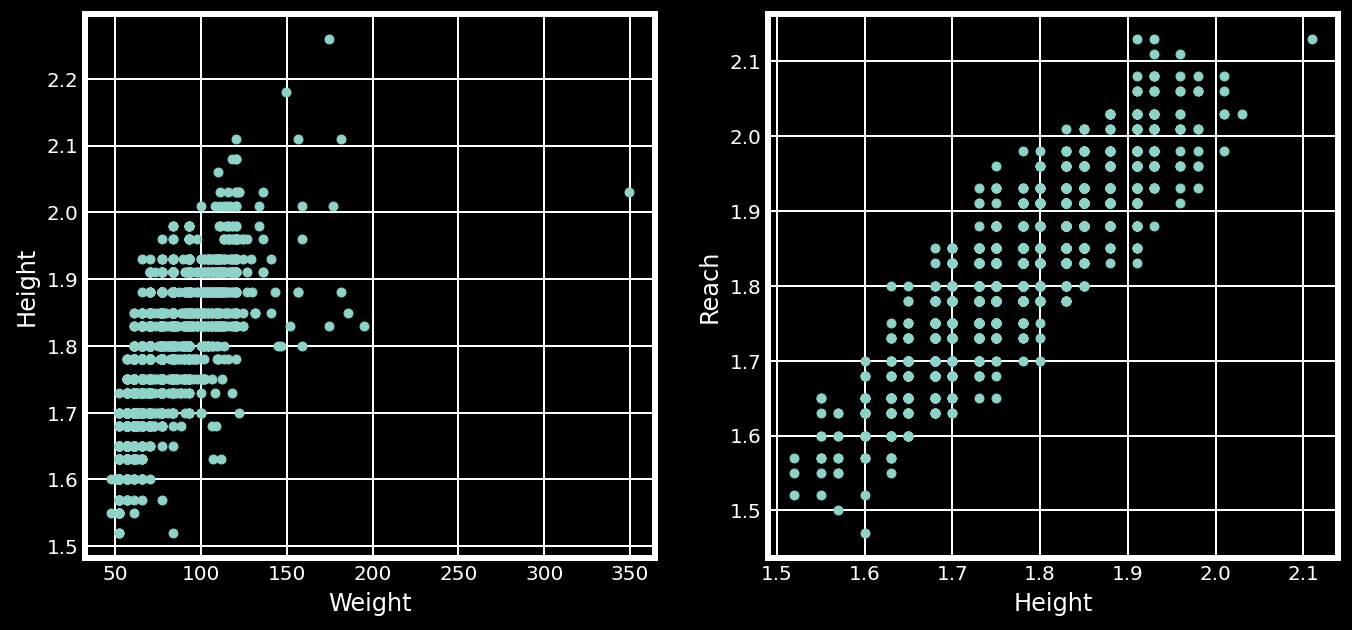

In [329]:
fig , ax = plt.subplots(ncols = 2, figsize = (10,5))
static_stats.plot('Weight', 'Height', kind = 'scatter' , ax = ax[0] )
static_stats.plot('Height', 'Reach', kind = 'scatter',  ax = ax[1])

In [330]:
## There is a pretty strong ratio between Height/Weight/Reach
## Therefore if with have any of these values we can deduce the others using the ratio based off the whole weightclass mean
## We don't need reach height as there are no data points that have Reach that don't have height

hw = (static_stats['Weight']/static_stats['Height']).mean()
wh = (static_stats['Height']/static_stats['Weight']).mean()
hr = (static_stats['Reach']/static_stats['Height']).mean()

In [331]:
## We can then impute the new information using the ratios

static_stats['Weight'] = static_stats.apply(lambda x: x['Height'] * hw if  np.isnan(x['Weight']) else x['Weight'], axis = 1)
static_stats['Height'] = static_stats.apply(lambda x: x['Weight'] * wh if  np.isnan(x['Height']) else x['Height'], axis = 1)          
static_stats['Reach'] = static_stats.apply(lambda x: x['Height'] * hr if  np.isnan(x['Reach']) else x['Reach'], axis = 1) 



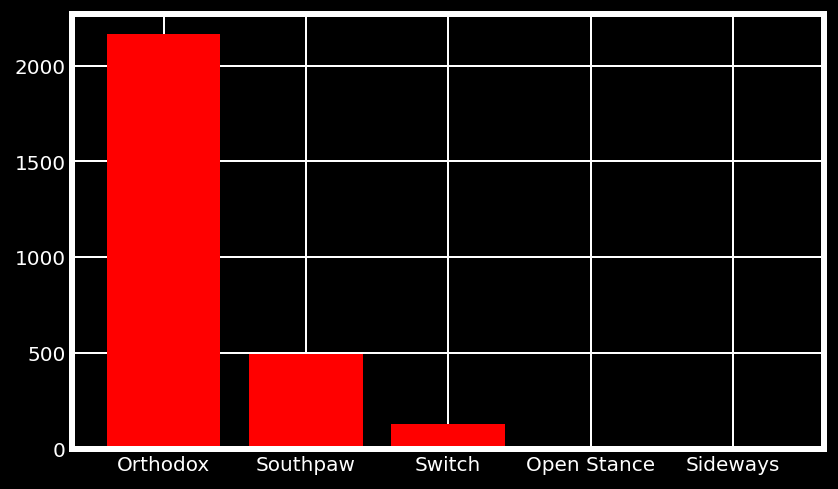

In [332]:
## The majortiy of stance is Orthodox and so we can make the assuption that NAs will most likely be Orthodox 
stance = raw_fighter_details.Stance.value_counts()
plt.bar(stance.index, list(stance),color = 'red')
plt.show()
static_stats['Stance'] = static_stats.Stance.fillna('Orthodox')

In [333]:
import requests
import bs4
from bs4 import BeautifulSoup
url = "https://www.sportskeeda.com/mma/ufc-weight-classes"
dfs = pd.read_html(url)


weight_classes  = dfs[0]
new_header = weight_classes.iloc[0] #grab the first row for the header
weight_classes = weight_classes[1:] #take the data less the header row
weight_classes.columns = new_header #set the header row as the df header

new_mins = []
for txt in weight_classes['Minimum Weight']:
    x = re.findall('\((.*?)\;', txt)[0]
    new_mins.append(float(re.findall(r"\d*\.?\d*", x)[0]))
weight_classes['Minimum Weight'] = new_mins

new_max = []
for txt in weight_classes['Upper Weight Limit']:
    x = re.findall('\((.*?)\;', txt)[0]
    new_max.append(float(re.findall(r"\d*\.?\d*", x)[0]))
weight_classes['Upper Weight Limit'] = new_max


weight_classes

C:\Users\jimmy\AppData\Local\Temp/ipykernel_26592/853854550.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jimmy\AppData\Local\Temp/ipykernel_26592/853854550.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0       Weight Class Name  Minimum Weight  Upper Weight Limit  \
1     Women's Strawweight            48.0                52.2   
2               Flyweight            52.2                56.7   
3            Bantamweight            56.7                61.2   
4           Featherweight            61.2                65.8   
5             Lightweight            65.8                70.3   
6            Welterweight            70.3                77.1   
7            Middleweight            77.1                83.9   
8       Light Heavyweight            83.9                93.0   
9             Heavyweight            93.0               120.2   
10      Women’s Flyweight            52.2                56.7   
11   Women’s Bantamweight            56.7                61.2   
12  Women’s Featherweight            61.2                65.8   

0        Current Champion  
1          Rose Namajunas  
2          Brandon Moreno  
3       Aljamain Sterling  
4   Alexander Volkanovski  
5        Charles Oliveira  
6            Kamaru Usman  
7         Israel Adesanya  
8         Glover Teixeira  
9         Francis Ngannou  
10   Valentina Shevchenko  
11          Julianna Peña  
12           Amanda Nunes

In [334]:
weight_classes.to_csv('weight classes.csv')

##### Fight Data

In [335]:
## I do not like '.' in columns
raw_total_fight_data.columns = [col.replace('.','') for col in raw_total_fight_data.columns ] 
[col for col in raw_total_fight_data.columns if '.' in col]

[]

In [336]:
def isNaN(num):
    return num != num

In [337]:
raw_total_fight_data.head(1)

R_fighter      B_fighter  R_KD  B_KD  R_SIG_STR B_SIG_STR R_SIG_STR_pct  \
0  Adrian Yanez  Gustavo Lopez     2     0  41 of 103  23 of 51           39%   

  B_SIG_STR_pct R_TOTAL_STR B_TOTAL_STR  ... B_GROUND  win_by last_round  \
0           45%   41 of 103    23 of 51  ...   0 of 0  KO/TKO          3   

  last_round_time         Format        Referee            date  \
0            0:27  3 Rnd (5-5-5)  Chris Tognoni  March 20, 2021   

                 location         Fight_type        Winner  
0  Las Vegas, Nevada, USA  Bantamweight Bout  Adrian Yanez  

[1 rows x 41 columns]

In [338]:
#raw_total_fight_data = pd.read_csv('UFC data/raw_total_fight_data.csv', sep=';')
#seperate columns that contain 'of'
of_cols = []
for j,x in zip(raw_total_fight_data.iloc[0].index,raw_total_fight_data.iloc[0]) :
    if 'of' in str(x):
        of_cols.append(j)

print(of_cols)        

#seperate columns that contain pct(percentage) 
pct_cols = []
for j,x in zip(raw_total_fight_data.iloc[1].index,raw_total_fight_data.iloc[0]) :
    if 'pct' in str(j):
        pct_cols.append(j)

print(pct_cols)

#Break out the of columns in to attempted and landed 5 of 10 means 5 strikes landed for 10 thrown
for col in of_cols:
    raw_total_fight_data[col+'_landed'] = raw_total_fight_data[col].apply(lambda x :float(re.findall('[0-9]+',x.replace(',', ''))[0]))
    raw_total_fight_data[col+'_attempted'] = raw_total_fight_data[col].apply(lambda x :float(re.findall('[0-9]+',x.replace(',', ''))[1]))
    raw_total_fight_data.drop(columns = col, inplace = True)

#Convert percenatges into float    
for col in pct_cols:
    raw_total_fight_data[col] = raw_total_fight_data[col].apply(lambda x : float(x.replace("%", "") if x != '---' else np.nan))

#Convert last round time into seconds
raw_total_fight_data['last_round_time'] = raw_total_fight_data.last_round_time.apply(lambda x: float(x.split(':')[0]) * 60 + float(x.split(':')[1]) if x != '--' else np.nan) 

#Convert missing data in NaN we can access what to do with them later
raw_total_fight_data = raw_total_fight_data.applymap(lambda x: np.nan if x in ['---','--'] else x)

#Convert date in to datetime
raw_total_fight_data['date'] = raw_total_fight_data['date'].apply(lambda x: pd.to_datetime(x))


#Convert the time into seconds for ground control 
raw_total_fight_data['R_CTRL'] = raw_total_fight_data.R_CTRL.apply(lambda x: np.nan if isNaN(x) else float(x.split(':')[0]) * 60 + float(x.split(':')[1]) if (x != '--')  else np.nan)
raw_total_fight_data['B_CTRL'] = raw_total_fight_data.B_CTRL.apply(lambda x: np.nan if isNaN(x) else float(x.split(':')[0]) * 60 + float(x.split(':')[1]) if (x != '--')  else np.nan)

['R_SIG_STR', 'B_SIG_STR', 'R_TOTAL_STR', 'B_TOTAL_STR', 'R_TD', 'B_TD', 'R_HEAD', 'B_HEAD', 'R_BODY', 'B_BODY', 'R_LEG', 'B_LEG', 'R_DISTANCE', 'B_DISTANCE', 'R_CLINCH', 'B_CLINCH', 'R_GROUND', 'B_GROUND']
['R_SIG_STR_pct', 'B_SIG_STR_pct', 'R_TD_pct', 'B_TD_pct']


##### To work with the data we need to break up the fights into fighters and concat the Dataframes. That way we can engineer the data based on the fighter regarless of who they were up against. After we have done our engineering we can join the engineered dataset back on to the orginal. This is so that the for our predictor instead of seeing the stats for the current fight i.e things we don't know until post fight we have an aggreation of evrything that came before.

##### It also lets us do some interesting eda using timeseries to see the evolution fighting in the ufc

In [339]:
raw_total_fight_data.columns

Index(['R_fighter', 'B_fighter', 'R_KD', 'B_KD', 'R_SIG_STR_pct',
       'B_SIG_STR_pct', 'R_TD_pct', 'B_TD_pct', 'R_SUB_ATT', 'B_SUB_ATT',
       'R_REV', 'B_REV', 'R_CTRL', 'B_CTRL', 'win_by', 'last_round',
       'last_round_time', 'Format', 'Referee', 'date', 'location',
       'Fight_type', 'Winner', 'R_SIG_STR_landed', 'R_SIG_STR_attempted',
       'B_SIG_STR_landed', 'B_SIG_STR_attempted', 'R_TOTAL_STR_landed',
       'R_TOTAL_STR_attempted', 'B_TOTAL_STR_landed', 'B_TOTAL_STR_attempted',
       'R_TD_landed', 'R_TD_attempted', 'B_TD_landed', 'B_TD_attempted',
       'R_HEAD_landed', 'R_HEAD_attempted', 'B_HEAD_landed',
       'B_HEAD_attempted', 'R_BODY_landed', 'R_BODY_attempted',
       'B_BODY_landed', 'B_BODY_attempted', 'R_LEG_landed', 'R_LEG_attempted',
       'B_LEG_landed', 'B_LEG_attempted', 'R_DISTANCE_landed',
       'R_DISTANCE_attempted', 'B_DISTANCE_landed', 'B_DISTANCE_attempted',
       'R_CLINCH_landed', 'R_CLINCH_attempted', 'B_CLINCH_landed',
       'B_CLINCH

In [340]:
#Chop the data in half
fight_1 = raw_total_fight_data[[col for col in raw_total_fight_data.columns if col[:2] != 'B_' ]]
fight_1.columns = [col[2:] if col.startswith('R_') else col for col in raw_total_fight_data.columns if col[:2] != 'B_']
fight_2 = raw_total_fight_data[[col for col in raw_total_fight_data.columns if col[:2] != 'R_']]
fight_2.columns = [col[2:] if col.startswith('B_') else col for col in raw_total_fight_data.columns if col[:2] != 'R_']

#Check lengths of the halves
print(len(fight_1.columns))
print(len(fight_2.columns))

34
34


In [341]:
#we then stick it back together and add a count of 1 so we can apply a cumliative count further on
total_fight_info = pd.concat([fight_1, fight_2], ignore_index=True)
total_fight_info['count'] = 1

In [342]:
## we need to establish if they won the fight (regardless of who it was against)
total_fight_info['Winner'] = total_fight_info.apply(lambda x: 1 if x['Winner'] == x['fighter'] else 0 , axis = 1  )

<AxesSubplot:>

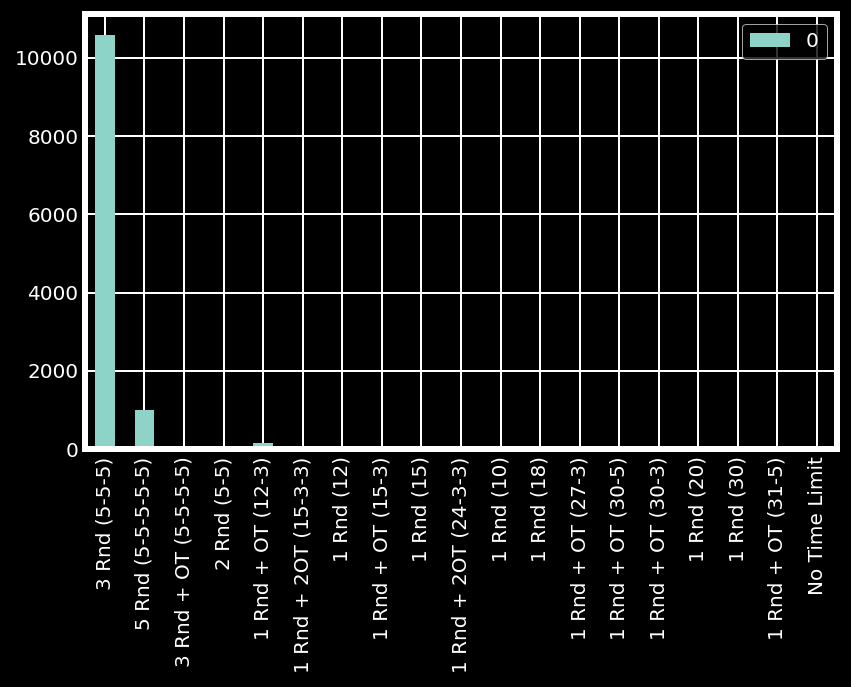

In [343]:
## The old format of figts is no longer used, we can change them to the 3 round 
## on the assumption that they would have been like this if they were held today
count = Counter(total_fight_info['Format'])
pd.DataFrame.from_dict(count, orient='index').plot(kind='bar')

In [344]:
## Convert all values other than 3/5 rounds to 3 rounds
total_fight_info['Format'] = total_fight_info['Format'].apply(lambda x: '3 Rnd (5-5-5)'  if x != '5 Rnd (5-5-5-5-5)' else x )

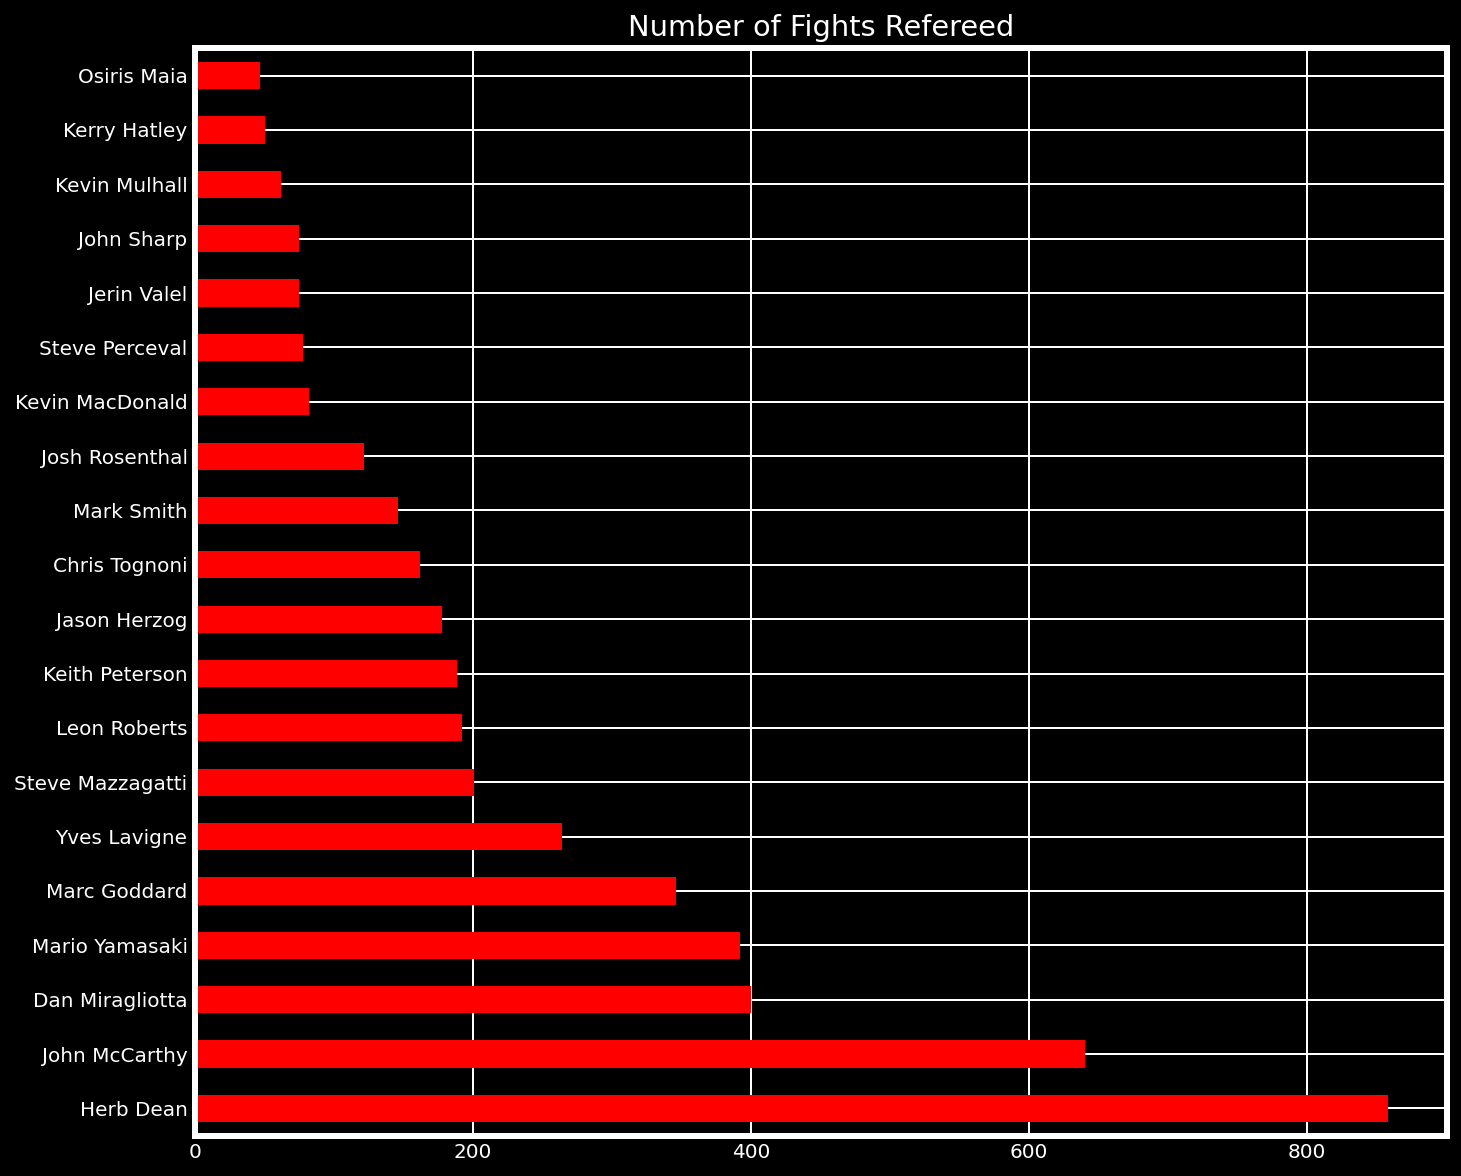

In [345]:
## Drop the columns we can't use, there are too many refs and they should not have an effect on the fight
## The vast majority of fights are Herb Dean and John McCarthy
refs = total_fight_info.Referee.value_counts()/2 
refs[:20].plot(kind='barh', color = 'red', figsize = (10,10))
plt.title('Number of Fights Refereed')
plt.savefig('refs.png',bbox_inches="tight")
total_fight_info.drop(columns = 'Referee' , inplace = True)

In [346]:
## We calulate the addition of the total rounds and last round time to work out the total fight time of each fight
total_fight_info['Fight_time'] = total_fight_info.apply(lambda x: (x.last_round * (5*60))  + x.last_round_time, axis = 1)


In [347]:
## Build a dictionary of the columns we want to sum and avergae
## We do this as some features we want to be cumliative and others we want to be an average
sumcount = {}
avg_cols = []
first_fight_cols = []

for col in total_fight_info.select_dtypes(['number']).columns:
    if ('fighter' in col)| ('date' in col):
        pass
    elif any(x in col for x in ['_by_','count','Winner','Fight_type','Format','Title']):
        sumcount[col] = 'sum'
    else:
        sumcount[col] = 'mean'
        if 'last' not in col:
            avg_cols.append(col)

In [348]:
## For the avg cols the vast majority of NaNs represent 0 values 
## total_fight_info[total_fight_info[avg_cols].isnull().any(axis = 1)]
nulls = total_fight_info[avg_cols].isnull().sum()
print(nulls.where(nulls > 0 , nulls))
total_fight_info[avg_cols] = total_fight_info[avg_cols].fillna(0)

KD                        0
SIG_STR_pct              86
TD_pct                 4131
SUB_ATT                   0
REV                       0
CTRL                    362
SIG_STR_landed            0
SIG_STR_attempted         0
TOTAL_STR_landed          0
TOTAL_STR_attempted       0
TD_landed                 0
TD_attempted              0
HEAD_landed               0
HEAD_attempted            0
BODY_landed               0
BODY_attempted            0
LEG_landed                0
LEG_attempted             0
DISTANCE_landed           0
DISTANCE_attempted        0
CLINCH_landed             0
CLINCH_attempted          0
GROUND_landed             0
GROUND_attempted          0
Fight_time                0
dtype: int64


In [349]:
## re-order the date so its at the front
total_fight_info = total_fight_info[['date'] + [col for col in total_fight_info.columns if 'date' not in col]]


In [352]:
total_fight_info

date             fighter  KD  SIG_STR_pct  TD_pct  SUB_ATT  REV  \
0     2021-03-20        Adrian Yanez   2         39.0     0.0        0    0   
1     2021-03-20        Trevin Giles   0         47.0    50.0        1    0   
2     2021-03-20         Tai Tuivasa   1         77.0     0.0        0    0   
3     2021-03-20       Cheyanne Buys   0         47.0     0.0        0    3   
4     2021-03-20       Marion Reneau   0         47.0    50.0        0    0   
...          ...                 ...  ..          ...     ...      ...  ...   
12019 1994-03-11  Alberta Cerra Leon   0         33.0     0.0        0    0   
12020 1994-03-11    Robert Lucarelli   0         33.0   100.0        1    0   
12021 1994-03-11       David Levicki   0         80.0     0.0        0    0   
12022 1994-03-11          Ray Wizard   0        100.0     0.0        0    0   
12023 1994-03-11      Sean Daugherty   0          0.0     0.0        0    0   

        CTRL                win_by  last_round  ...  LEG_landed LEG_attempted  \
0        3.0                KO/TKO           3  ...         1.0           1.0   
1       75.0  Decision - Unanimous           3  ...         1.0           2.0   
2       10.0                KO/TKO           1  ...         4.0           4.0   
3       64.0  Decision - Unanimous           3  ...         0.0           0.0   
4      135.0  Decision - Unanimous           3  ...         9.0          10.0   
...      ...                   ...         ...  ...         ...           ...   
12019    0.0            Submission           1  ...         0.0           0.0   
12020    0.0                KO/TKO           1  ...         1.0           3.0   
12021    0.0                KO/TKO           1  ...         0.0           0.0   
12022    0.0            Submission           1  ...         1.0           1.0   
12023    0.0            Submission           1  ...         0.0           2.0   

      DISTANCE_landed DISTANCE_attempted  CLINCH_landed  CLINCH_attempted  \
0                41.0              102.0            0.0               0.0   
1                15.0               42.0            4.0               5.0   
2                 9.0               10.0            0.0               0.0   
3                26.0               56.0            2.0               2.0   
4                25.0               54.0            5.0               9.0   
...               ...                ...            ...               ...   
12019             1.0                1.0            0.0               0.0   
12020             2.0                6.0            0.0               0.0   
12021             1.0                2.0            2.0               2.0   
12022             1.0                1.0            0.0               0.0   
12023             0.0                3.0            0.0               1.0   

       GROUND_landed  GROUND_attempted  count  Fight_time  
0                0.0               1.0      1       927.0  
1                8.0              10.0      1      1200.0  
2                5.0               8.0      1       349.0  
3                3.0               7.0      1      1200.0  
4                0.0               0.0      1      1200.0  
...              ...               ...    ...         ...  
12019            0.0               2.0      1       891.0  
12020            0.0               0.0      1       470.0  
12021            1.0               1.0      1      1033.0  
12022            0.0               0.0      1       358.0  
12023            0.0               0.0      1       320.0  

[12024 rows x 35 columns]

In [351]:
import plotly.express as px

df_map = total_fight_info.copy()
df_map['year'] =  df_map['date'].dt.year

lenx = []
city = []
state = [] 
country = [] 
for x in df_map['location'].apply(lambda x: x.split(',')):
    lenx.append(len(x))
    if len(x) != 3:
        city.append(x[0].strip())
        state.append(None)
        country.append(x[1].strip())
    else:
        city.append(x[0].strip())
        state.append(x[1].strip())
        country.append(x[2].strip())
    
df_map['city'] = city
df_map['state'] = state
df_map['Country'] = country


df_map = df_map.reset_index(drop = True).drop(columns = ['location'])
cities = df_map
df_map = df_map.groupby(['year','Country']).count()[['count']].reset_index()


for n,loc in enumerate(df_map.Country.unique()):
    df_loc = df_map[df_map['Country'] == loc] 
    df_loc['fights'] = df_loc['count'].cumsum()
    if n == 0:
        df_map_cs = df_loc
    else: 
        df_map_cs = pd.concat([df_map_cs,df_loc])
        
df_map = df_map_cs.sort_values(by = 'year')

i = range(1994,2022)

df_map = df_map.set_index('year').groupby('Country',group_keys=False)\
        .apply(lambda s: s.reindex(i).ffill()).reset_index()
    
df_map.dropna(inplace = True)
df_map = df_map.sort_values(by = 'year')


C:\Users\jimmy\AppData\Local\Temp/ipykernel_26592/772318898.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [323]:
fig = px.scatter_geo(df_map
                     , locations="Country"
                     #, color="Country"
                     , locationmode='country names' 
                     , size="fights",
                     animation_frame="year",
                     projection="natural earth")
fig.show()

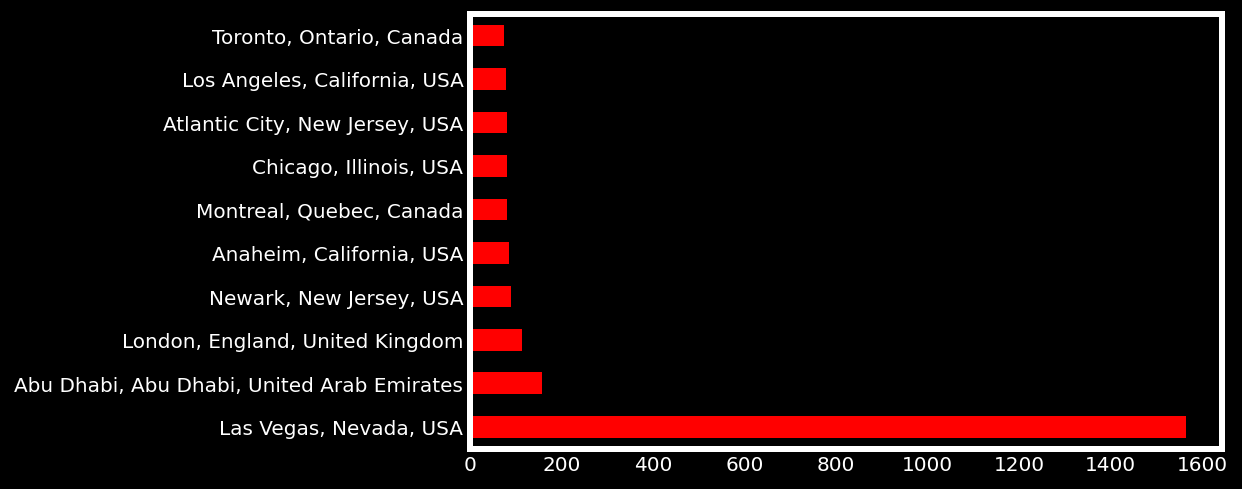

In [353]:
location = total_fight_info.location.value_counts()/2 
location[:10].plot(kind='barh' , color = 'red')
plt.grid(False)
plt.savefig('locations.png',bbox_inches="tight")
plt.show()
## LAS VEGAS the official home of the ufc
total_fight_info.drop(columns = 'location' , inplace = True)

<AxesSubplot:>

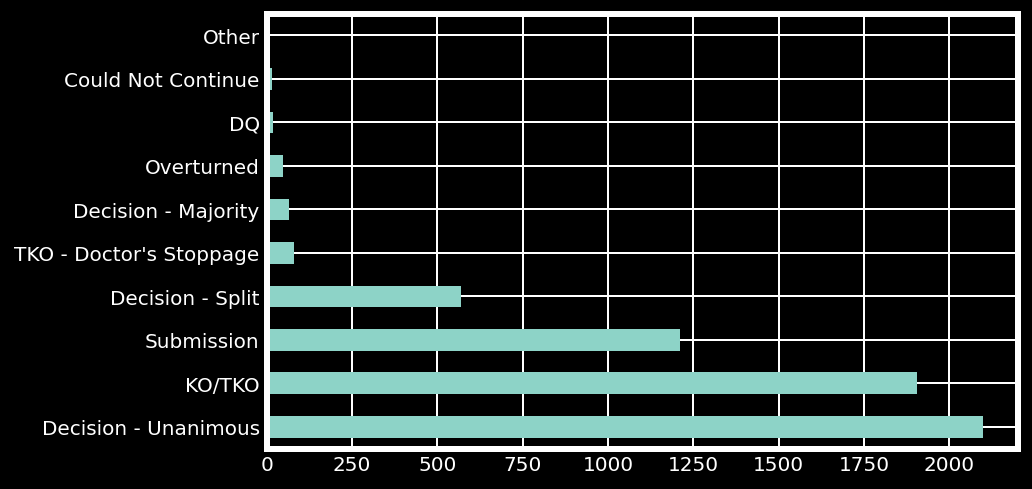

In [354]:
## The Majority of fights are won by Decicion
winby = total_fight_info.win_by.value_counts()/2 
winby[:20].plot(kind='barh')

In [33]:
## Overturned is means they tested poitive after the fight for drugs 

In [355]:
total_fight_info.win_by.unique()

win_by_method = {"TKO - Doctor's Stoppage": 'KO/TKO'
,'Other' : 'Decision - Unanimous'
,'Overturned': 'Decision - Unanimous'
,'Decision - Majority' : 'Decision - Split'
,'Could Not Continue' : 'KO/TKO'
,'DQ': 'Decision - Split'}

total_fight_info.win_by.replace(win_by_method, inplace = True)

In [356]:
## Convert the Fight type into the weight class and Title(was it a title fight) columns

weights  = [x.replace(' Bout', '') for x in total_fight_info.Fight_type.value_counts().head(12).index.tolist()]

weights_mydic = {}
for x in total_fight_info['Fight_type']:
    for w in weights:
        if w in x:
            weights_mydic[x] = w
            
for x in total_fight_info['Fight_type']:
    if x not in weights_mydic.keys():
        weights_mydic[x] = 'Open Weight'

In [357]:
total_fight_info['Fight_type'].replace(weights_mydic, inplace = True )    
total_fight_info['Title_win'] = total_fight_info.apply(lambda x: 1 if ('Title'  in x['Fight_type'])& x['Winner'] == 1 else 0 , axis = 1 )
total_fight_info['Title'] = total_fight_info['Fight_type'].apply(lambda x: 1 if 'Title'  in x else 0 )

In [358]:
sorter = ['Heavyweight','Light Heavyweight','Middleweight',
        'Welterweight', 'Lightweight','Featherweight',
       'Bantamweight', 'Flyweight',"Women's Bantamweight", 
       "Women's Flyweight", "Women's Strawweight",'Open Weight']

C:\Users\jimmy\anaconda3\lib\site-packages\pandas\core\arrays\categorical.py:2631: FutureWarning:

The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.



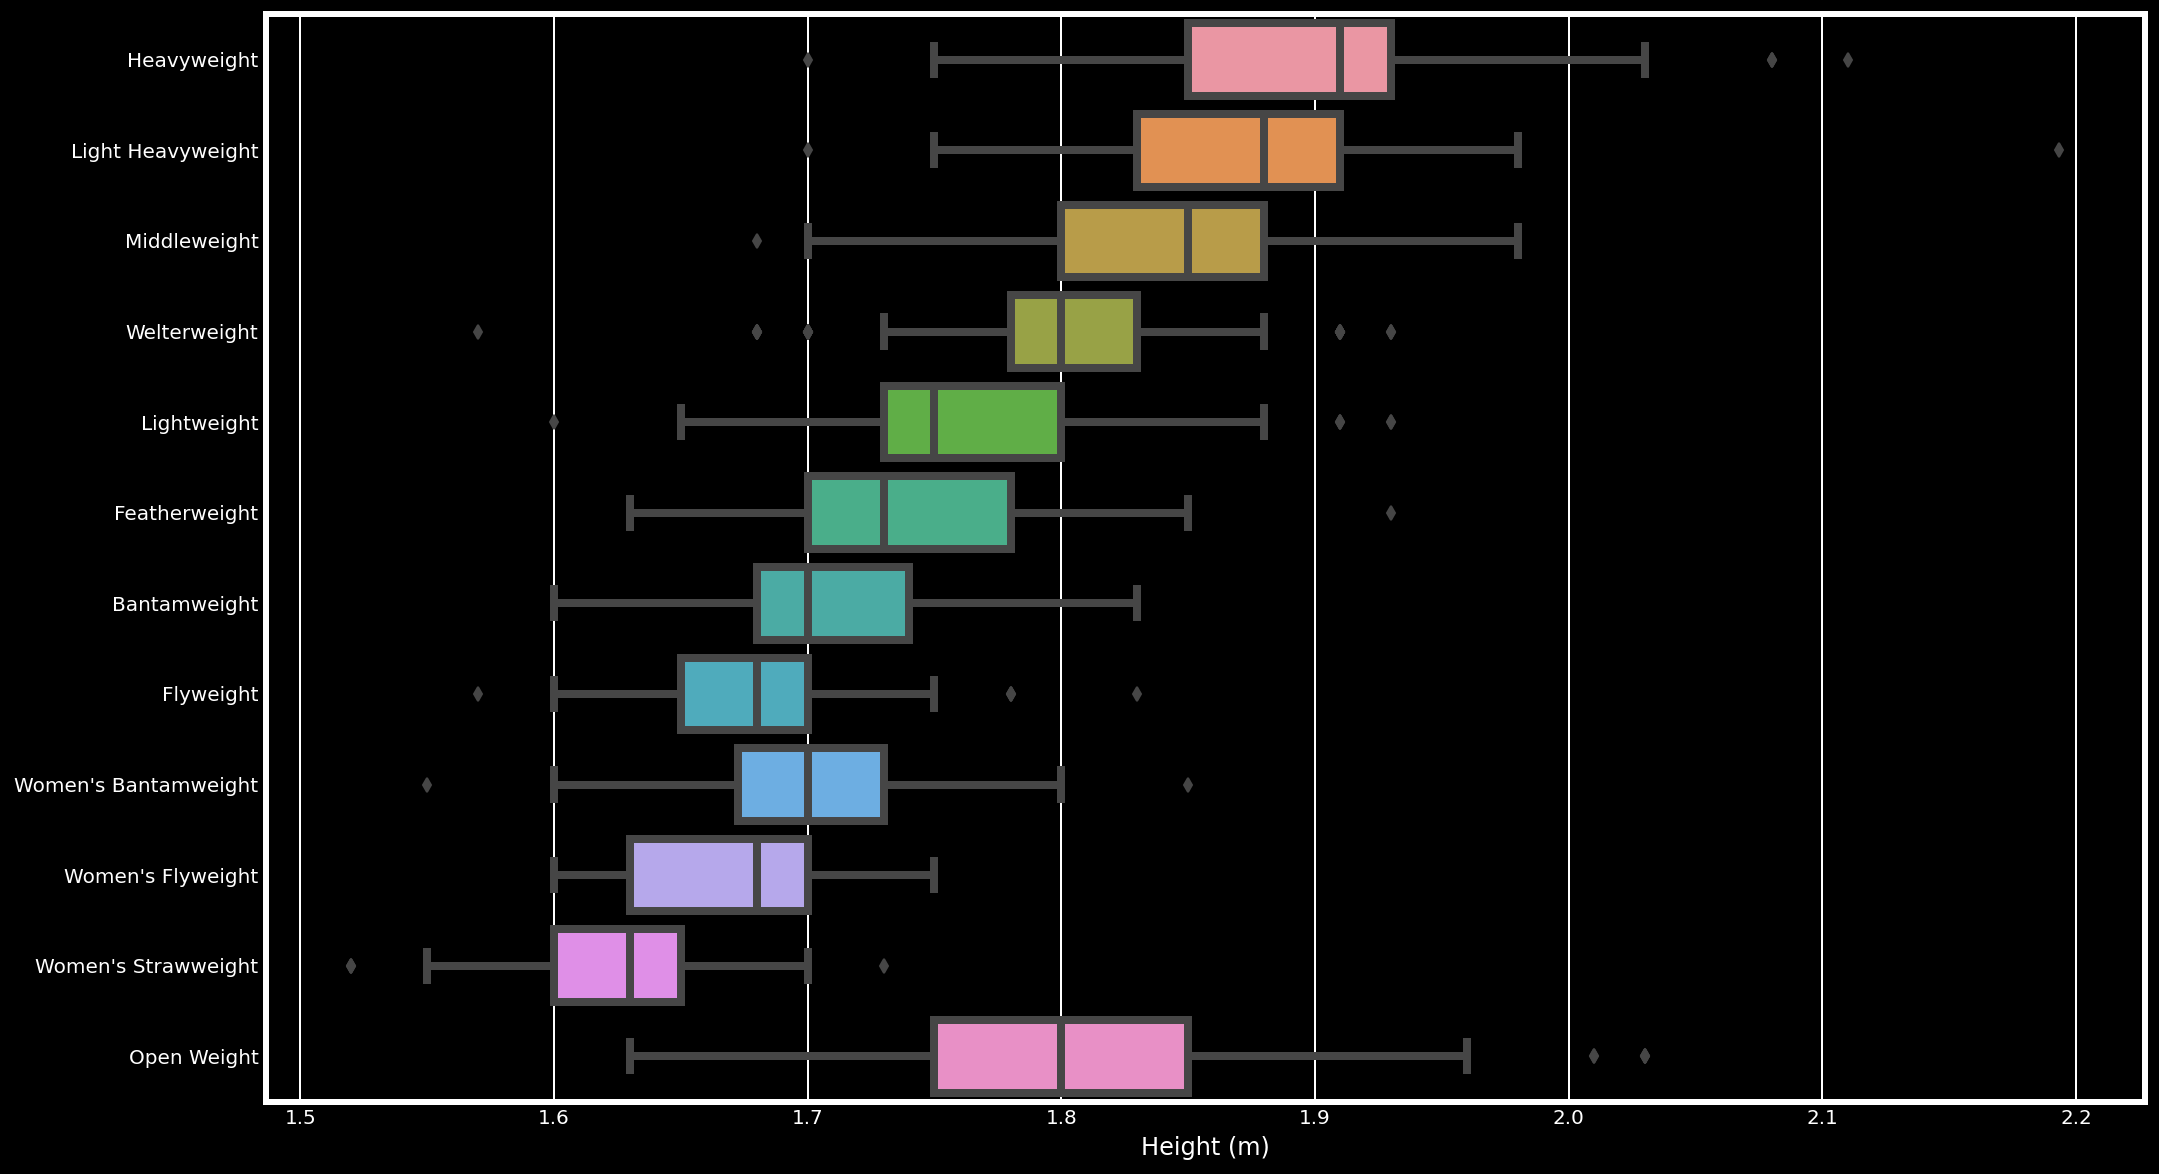

In [146]:
df = weightz.reset_index()
heightclass = static_stats.merge(df, how = 'inner', left_on ='fighter_name', right_on = 'fighter')[['Height','Fight_type']]
heightclass = heightclass.sort_values('Height', ascending=False)

heightclass.Fight_type = heightclass.Fight_type.astype("category")
heightclass.Fight_type.cat.set_categories(sorter, inplace=True)
heightclass = heightclass.sort_values(["Fight_type"])

plt.figure(figsize=(15,10))
sns.boxplot(data = heightclass.dropna(), x = 'Height', y = 'Fight_type')
plt.ylabel('')
plt.xlabel('Height (m)')
plt.savefig('Weight Classes.png', bbox_inches="tight")


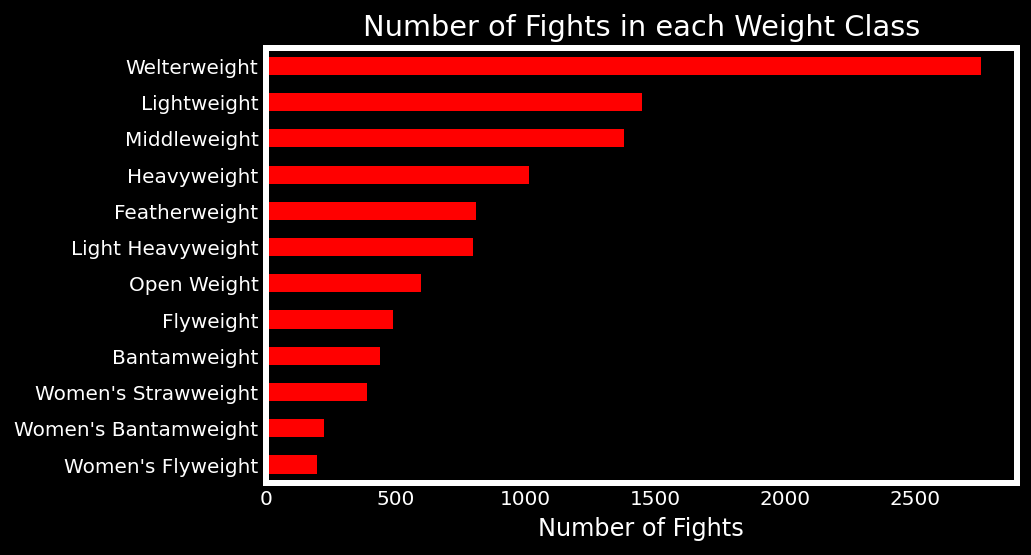

In [84]:
##Number of fights in each weight class
weightz = total_fight_info.groupby(['fighter','Fight_type'])[['count']].sum()
weightz = weightz.reset_index().groupby(['fighter']).max()
weightz.groupby('Fight_type').sum().sort_values(by = 'count').plot(kind= 'barh', color= 'red' ,legend = False)
plt.title('Number of Fights in each Weight Class')
plt.xlabel('Number of Fights')
plt.ylabel('')
plt.grid(False)
plt.savefig('Weight Classes.png', bbox_inches="tight")



### Looking at outliers

In [177]:
proper_names = {'KD' : 'Knockdowns',
'SIG_STR_pct' : 'Significant Strike Percentage',
'TD_pct' : 'Takedown',
'SUB_ATT' : 'Submission Attempts',
'REV' : 'Reversals',
'CTRL' : 'Control Time',
'SIG_STR_landed' : 'Significant Strike Landed',
'SIG_STR_attempted' : 'Significant Strike Attempted',
'TOTAL_STR_landed' : 'Total Strikes Landed',
'TOTAL_STR_attempted' : 'Total Strikes Attempted',
'TD_landed' : 'Takedown Landed',
'TD_attempted' : 'Takedown Attempted',
'HEAD_landed' : 'Head Shot Landed',
'HEAD_attempted' : 'Head Shot Attempted',
'BODY_landed' : 'Body Landed',
'BODY_attempted' : 'Body Attempted',
'LEG_landed' : 'Leg Landed',
'LEG_attempted' : 'Leg Attempted',
'DISTANCE_landed' : 'Distance Landed',
'DISTANCE_attempted' : 'Distance Attempted',
'CLINCH_landed' : 'Clinch Landed',
'CLINCH_attempted' : 'Clinch Attempted',
'GROUND_landed' : 'Ground Shots Landed',
'GROUND_attempted' : 'Ground Shots Attempted'}


C:\Users\jimmy\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



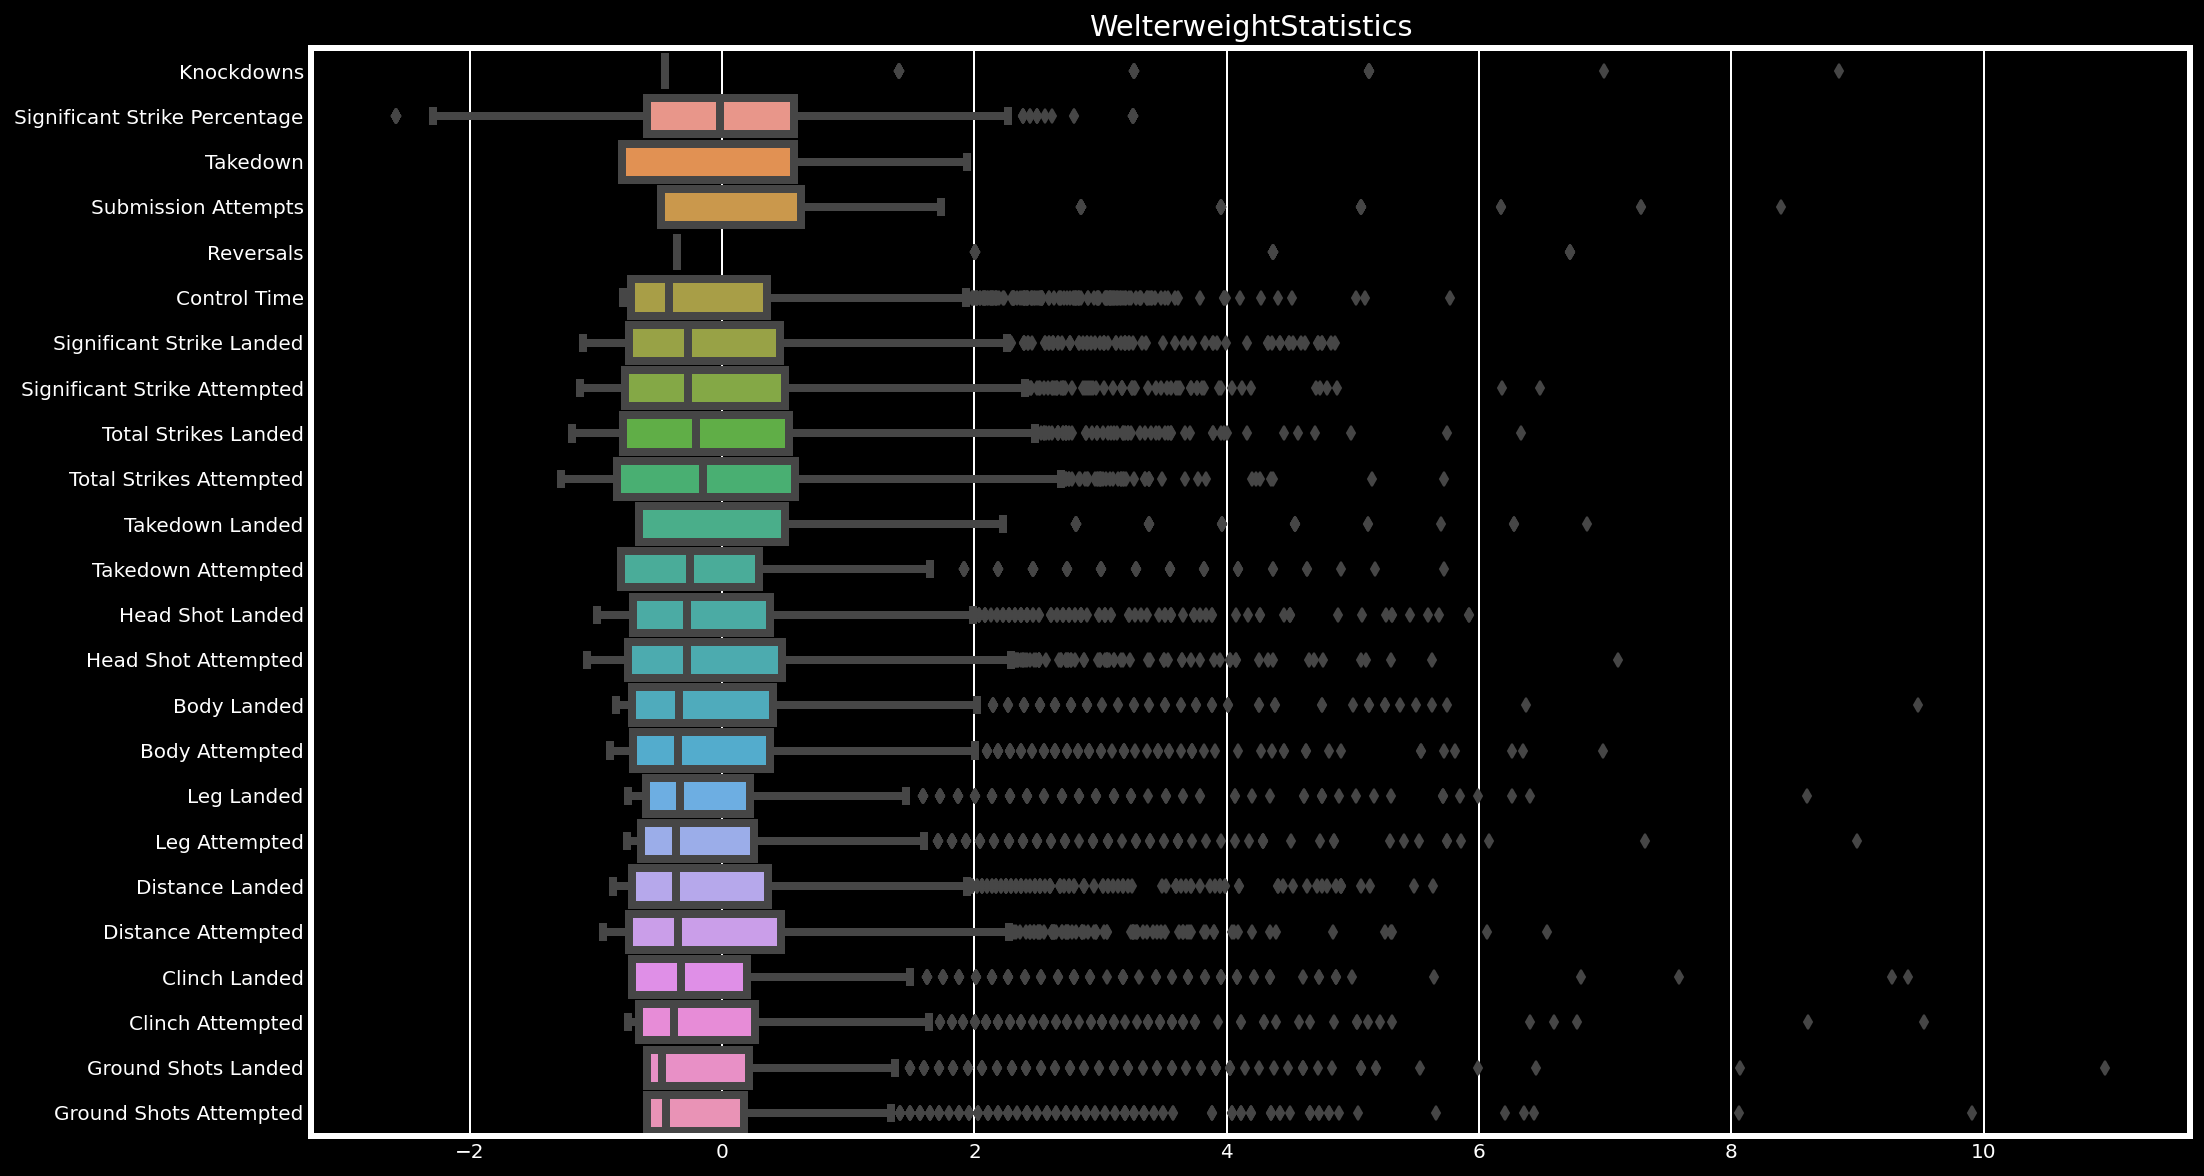

In [198]:
for Fight_type in ['Welterweight']: #total_fight_info.Fight_type.unique():
    #subset the data
    ft = total_fight_info[total_fight_info['Fight_type'] == Fight_type]
    ft.rename(columns = proper_names, inplace = True)
    
    #normalized_df=(ft-ft.mean())/ft.std()
    c_names = list(proper_names.values())
    ft = ft[c_names]
    
    x = ft.values #returns a numpy array
    ss = preprocessing.StandardScaler()
    x_scaled = ss.fit_transform(x)
    ft = pd.DataFrame(x_scaled, columns = c_names)
    
    
    plt.figure( figsize = (15,10))
    sns.boxplot(data = ft , orient="h" )
    plt.title(Fight_type+ 'Statistics')
    #plt.xticks(rotation = 90)
    #plt.xticks(ft.columns)
    plt.savefig('stats.png', bbox_inches="tight")
    plt.show()
    #fig, ax =  plt.subplots(ncols = len(ft.select_dtypes(['number']).columns))
    #for n,col in enumerate(ft.select_dtypes(['number']).columns):
    #sns.boxplot(ft[''])
    
    #plt.show()

### As expected in a combat sport you have many outliers as it is so unpredicatable and tactics change from fight to fight, I do not want to drop any outliers

In [359]:
## win by only applies to the winnner of the fight so we need to add a loss by column
total_fight_info['loss_by'] = total_fight_info.apply(lambda x: x.win_by if x.Winner == 0 else None , axis = 1 )

In [360]:
## Add in the class the fight was at and if they won or lost
## eg. you will see Heavyweight_wins 

In [361]:
total_fight_info['Fight_type_loss'] = total_fight_info.apply(lambda x: x.Fight_type if x.Winner == 0 else None , axis = 1 )
total_fight_info['Fight_type_win'] = total_fight_info.apply(lambda x: x.Fight_type if x.Winner == 1 else None , axis = 1 )

In [362]:
total_fight_final = pd.get_dummies(total_fight_info,columns =  ['Format','Fight_type_loss','Fight_type_win', 'loss_by', 'win_by'] )

In [363]:
# drop features that are no longer important because they are captured in other parts of the dataframe
total_fight_final.drop(columns = ['Fight_type','last_round','last_round_time'] , inplace = True)

#### Time Plotting, How fights have changed over the years

In [364]:
## Build a dictionary of the columns we want to sum and avergae
sumcount = {}
avg_cols = []
first_fight_cols = []

for col in total_fight_final.select_dtypes(['number']).columns:
    if ('fighter' in col)| ( 'date' in col):
        pass
    elif any(x in col for x in ['_by_','count','Winner','Fight_type','Format','Title']):
        sumcount[col] = 'sum'
    else:
        sumcount[col] = 'mean'
        if 'last' not in col:
            avg_cols.append(col)

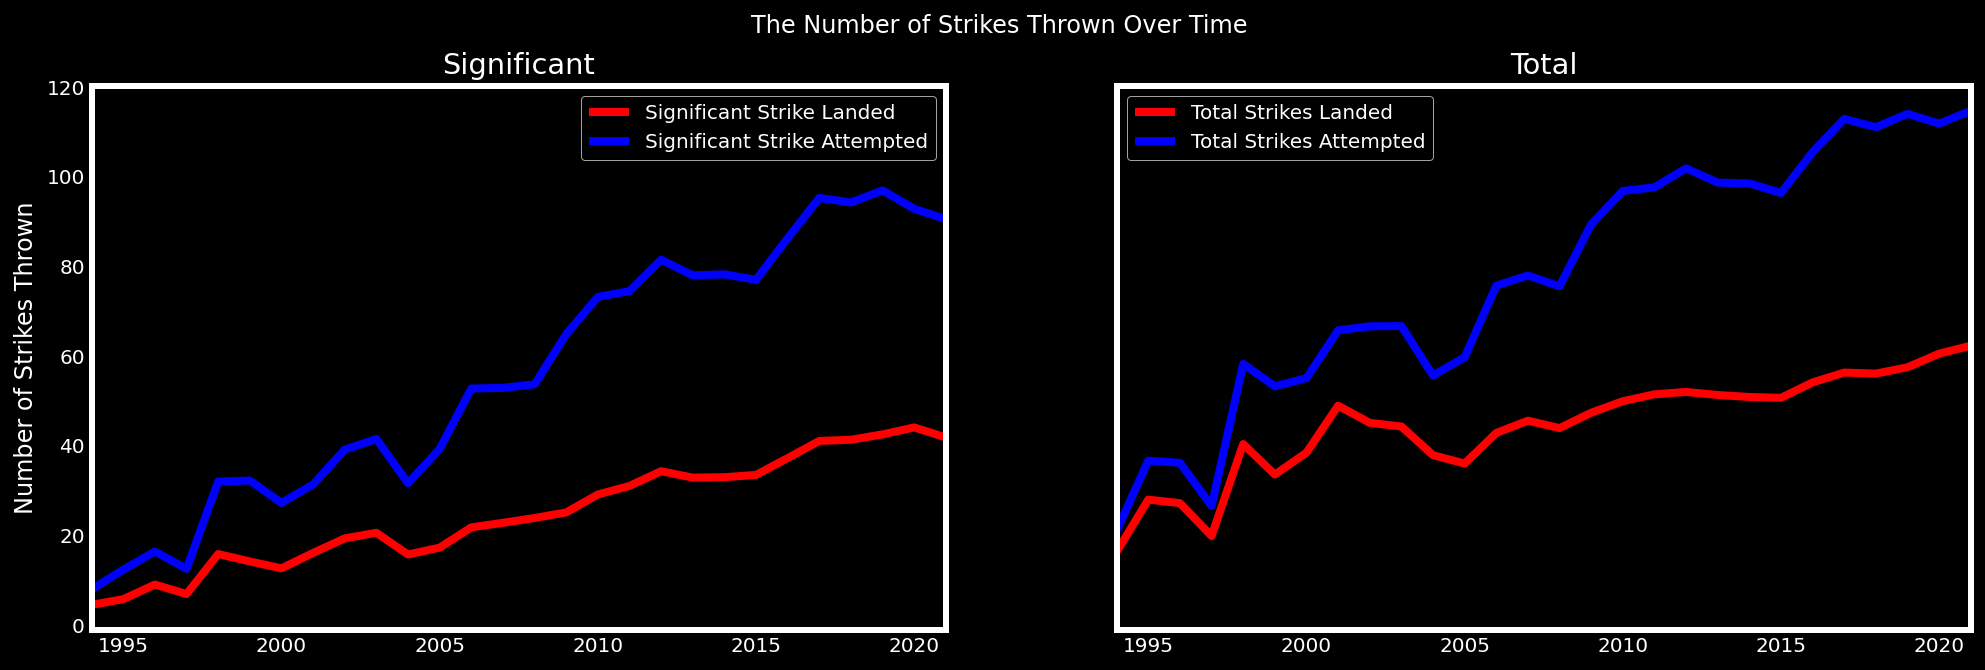

In [404]:
date_info = total_fight_final.set_index('date')
date_info = date_info.select_dtypes(['number'])
date_info_A = date_info.resample('A').agg(sumcount)
date_info_A.rename(columns = proper_names, inplace = True)


fig , ax = plt.subplots(ncols = 2, figsize = (15,5), sharey=True)
fig.suptitle("The Number of Strikes Thrown Over Time")
date_info_A[['Significant Strike Landed','Significant Strike Attempted']].plot(color = ['red','blue'], ax = ax[0],grid = False, ylabel = 'Number of Strikes Thrown', xlabel = '', title = 'Significant')
#plt.grid(False)
date_info_A[['Total Strikes Landed','Total Strikes Attempted']].plot(color = ['red','blue'], ax = ax[1],grid = False, xlabel = '', title = 'Total')
#plt.grid(False)
plt.savefig('fight_q1.png', bbox_inches="tight")
plt.show()





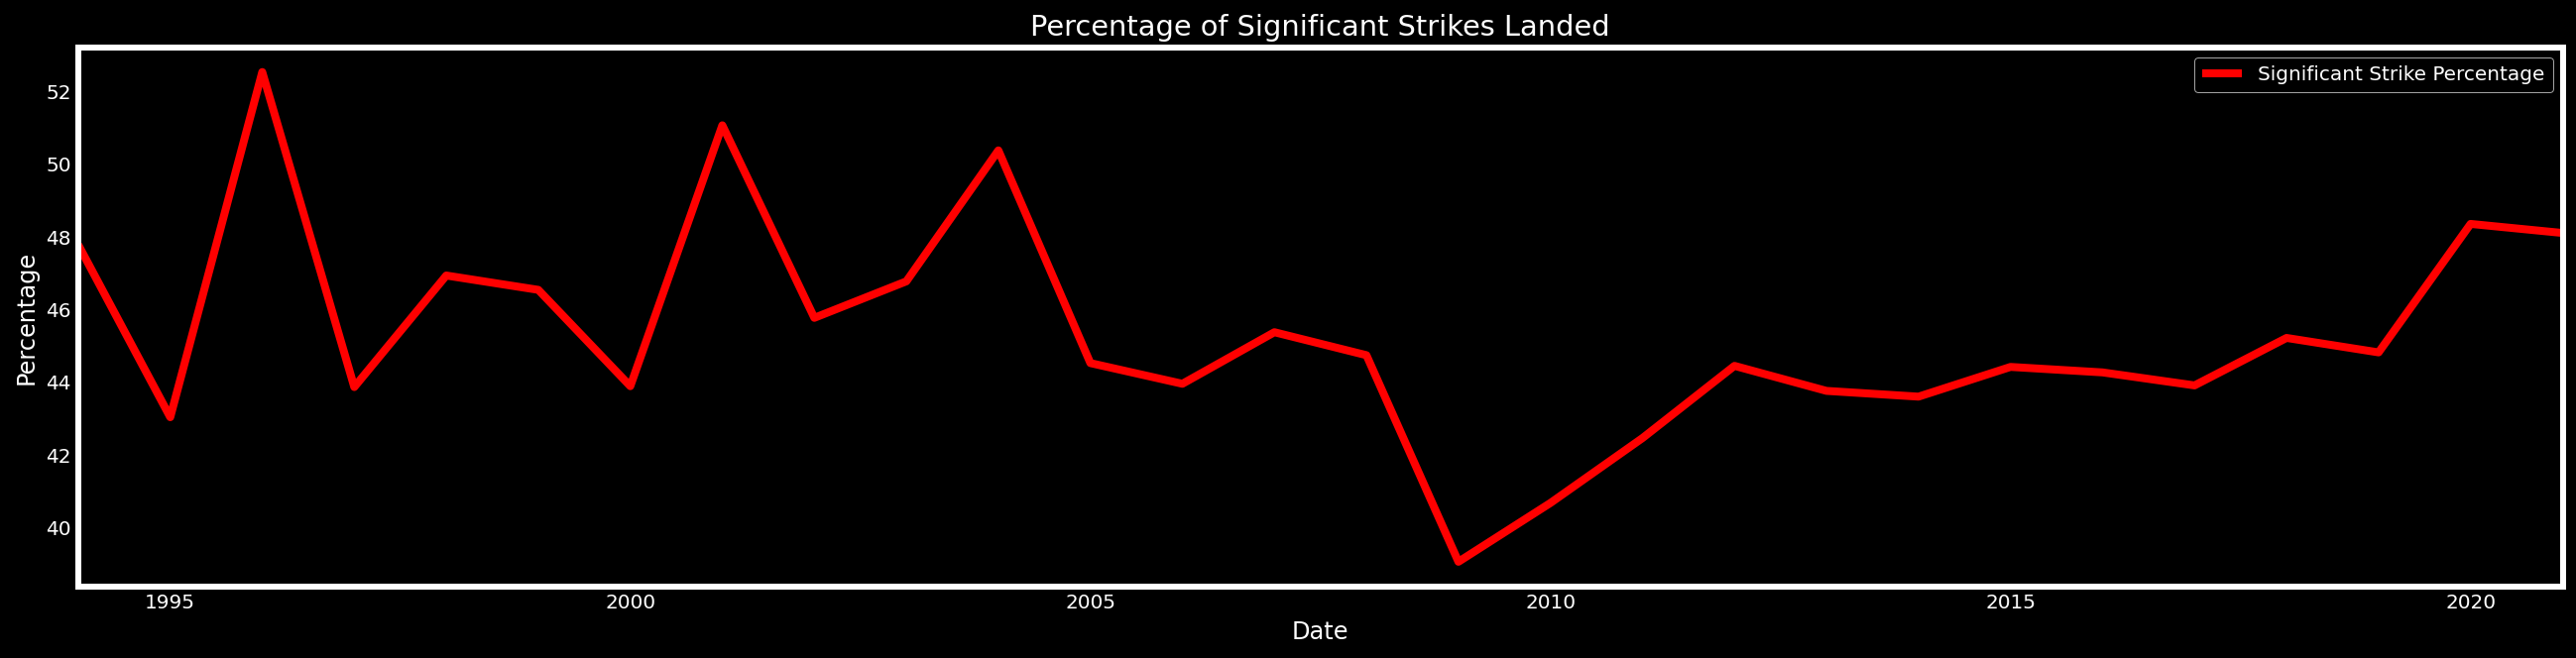

In [260]:
date_info_A[['Significant Strike Percentage']].plot(figsize = (20,5) , color = 'red', grid = False, ylabel = 'Percentage', xlabel = 'Date', legend = True, title = 'Percentage of Significant Strikes Landed' )
plt.savefig('SignificantStrikePercentage.png', bbox_inches="tight")

In [406]:
date_info_A['Decision'] = date_info_A.apply(lambda x: (x[[col for col in date_info_A.columns if ('Decision' in col) & ('win_by' in col)]].sum()/x['count']) * 100 ,axis = 1 )
date_info_A['KO']  = date_info_A.apply(lambda x: (x[[col for col in date_info_A.columns if ('KO'  in col) & ('win_by' in col)]].sum()/x['count'])* 100 ,axis = 1 )
date_info_A['Submission'] = date_info_A.apply(lambda x: (x[[col for col in date_info_A.columns if ('Submission' in col) & ('win_by' in col)]].sum()/x['count']) * 100,axis = 1 )
#date_info_A['Other']  = date_info_A.apply(lambda x: x[[col for col in date_info_A.columns if any(ext not in col for ext in ['Submission','KO','Decision'])]].sum()/x['count'],axis = 1 )


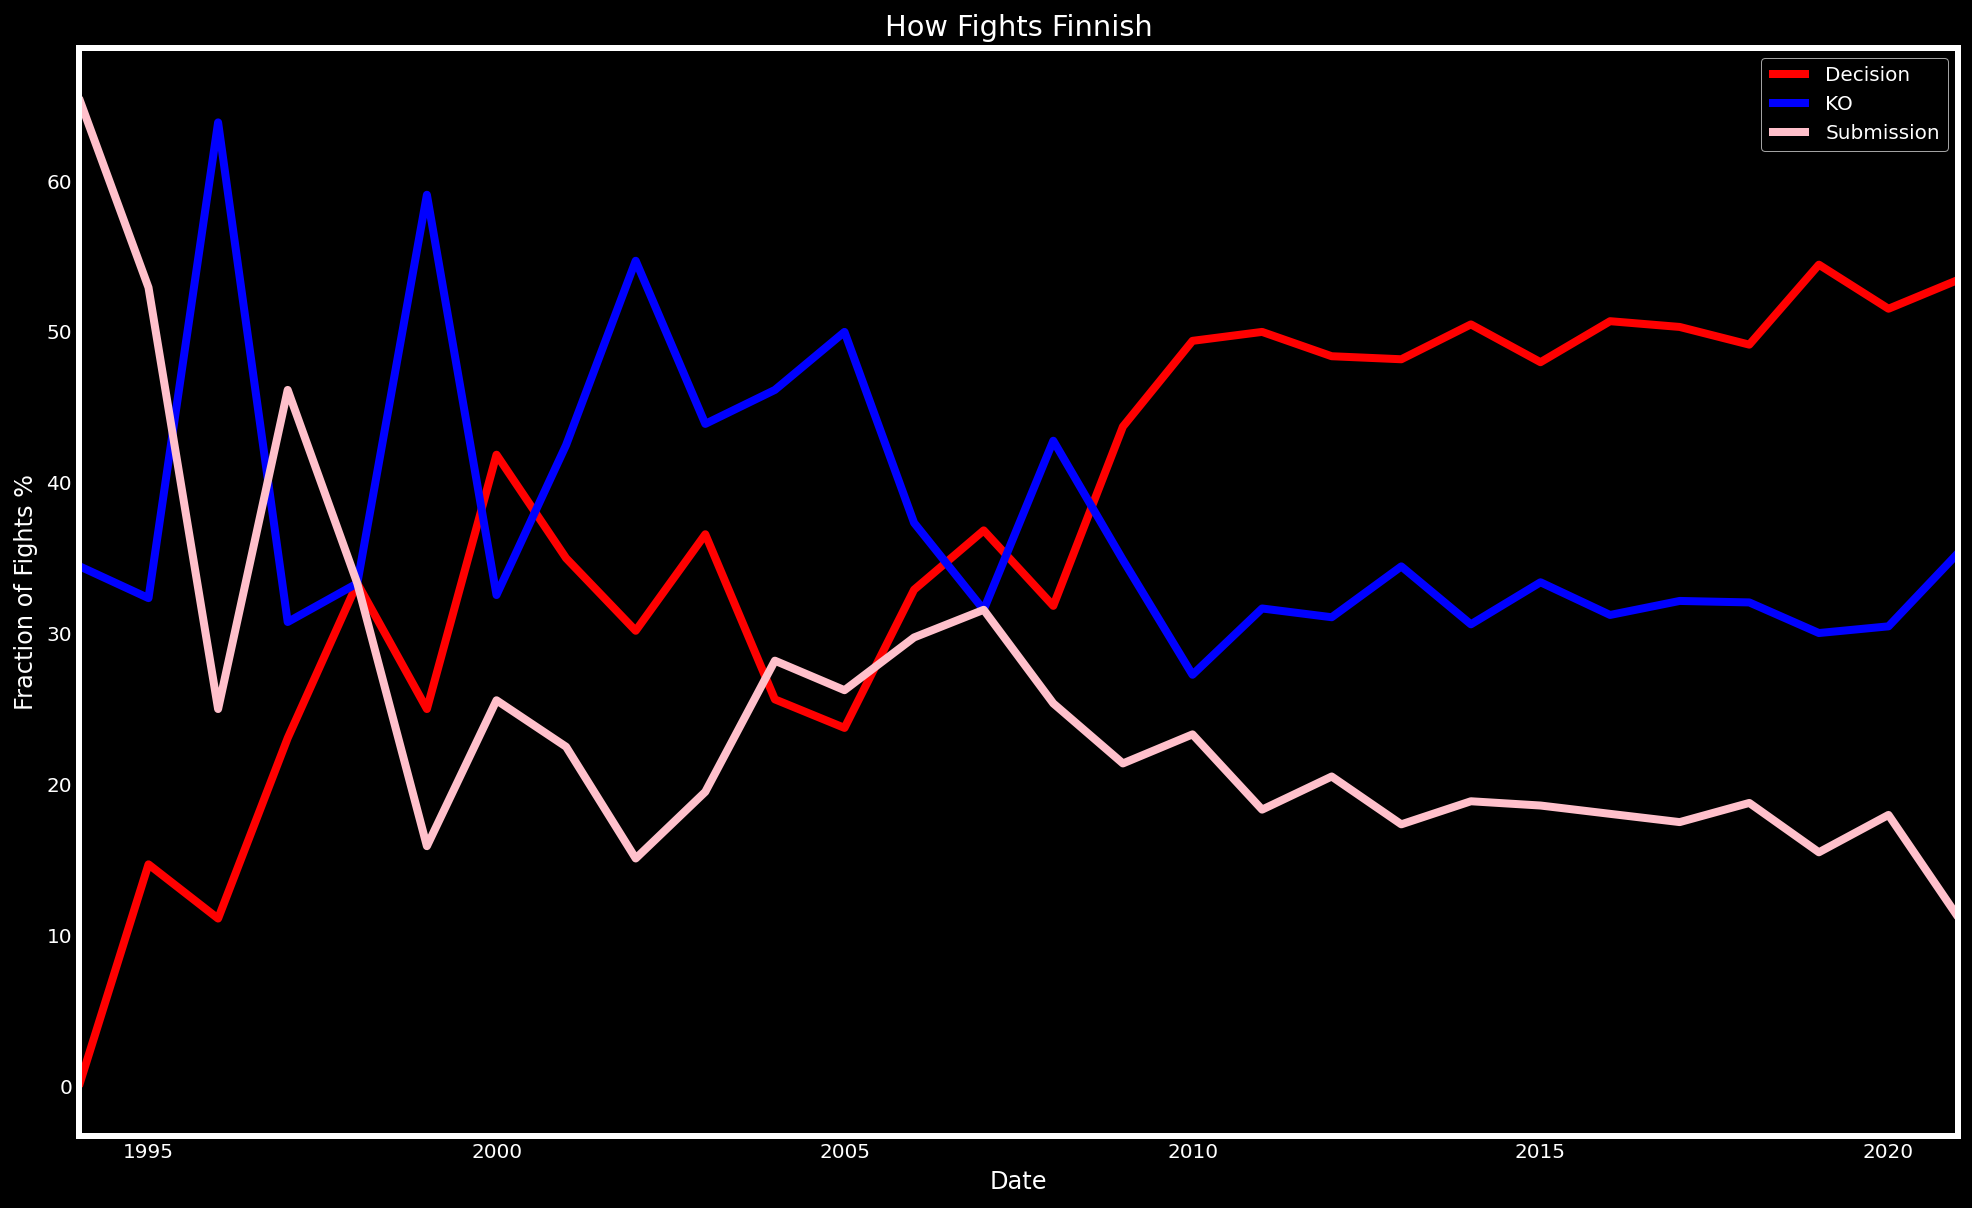

In [407]:
date_info_A[['Decision','KO','Submission']].plot(figsize= (15,10), color = ['red','blue', 'pink'])
plt.title('How Fights Finnish')
plt.ylabel('Fraction of Fights %')
plt.xlabel('Date')
plt.grid(False)
plt.savefig('fightfinnish.png', bbox_inches="tight")

## Work out rolling average

In [366]:
df_tff = total_fight_final.copy()

In [367]:
df_tff['first_fight'] = 1 * (
    df_tff.groupby('fighter')['date'].transform('min') == df_tff['date']
)

In [368]:
df_tff = df_tff.sort_values(by = 'date' , ascending = True)

In [369]:
df_tff = df_tff.set_index('date') 

In [370]:
df_tff

fighter  KD  SIG_STR_pct  TD_pct  SUB_ATT  REV   CTRL  \
date                                                                      
1994-03-11   Scott Morris   0        100.0   100.0        1    0    0.0   
1994-03-11   Royce Gracie   0          0.0    50.0        1    0    0.0   
1994-03-11  Remco Pardoel   0        100.0   100.0        0    0    0.0   
1994-03-11  Patrick Smith   0         41.0     0.0        1    0    0.0   
1994-03-11  Johnny Rhodes   1         44.0     0.0        1    0    0.0   
...                   ...  ..          ...     ...      ...  ...    ...   
2021-03-20  Kevin Holland   0         48.0   100.0        0    0  107.0   
2021-03-20  Jesse Strader   0         56.0     0.0        0    0    1.0   
2021-03-20        JP Buys   0         30.0     0.0        1    0   62.0   
2021-03-20  Roman Dolidze   0         47.0    33.0        2    1  255.0   
2021-03-20   Adrian Yanez   2         39.0     0.0        0    0    3.0   

            Winner  SIG_STR_landed  SIG_STR_attempted  ...  \
date                                                   ...   
1994-03-11       1             1.0                1.0  ...   
1994-03-11       1             0.0                0.0  ...   
1994-03-11       1             7.0                7.0  ...   
1994-03-11       1             5.0               12.0  ...   
1994-03-11       1            13.0               29.0  ...   
...            ...             ...                ...  ...   
2021-03-20       0            36.0               74.0  ...   
2021-03-20       0            14.0               25.0  ...   
2021-03-20       0            17.0               56.0  ...   
2021-03-20       0            32.0               67.0  ...   
2021-03-20       1            41.0              103.0  ...   

            Fight_type_win_Women's Strawweight  loss_by_Decision - Split  \
date                                                                       
1994-03-11                                   0                         0   
1994-03-11                                   0                         0   
1994-03-11                                   0                         0   
1994-03-11                                   0                         0   
1994-03-11                                   0                         0   
...                                        ...                       ...   
2021-03-20                                   0                         0   
2021-03-20                                   0                         0   
2021-03-20                                   0                         0   
2021-03-20                                   0                         0   
2021-03-20                                   0                         0   

            loss_by_Decision - Unanimous  loss_by_KO/TKO  loss_by_Submission  \
date                                                                           
1994-03-11                             0               0                   0   
1994-03-11                             0               0                   0   
1994-03-11                             0               0                   0   
1994-03-11                             0               0                   0   
1994-03-11                             0               0                   0   
...                                  ...             ...                 ...   
2021-03-20                             1               0                   0   
2021-03-20                             0               1                   0   
2021-03-20                             0               1                   0   
2021-03-20                             1               0                   0   
2021-03-20                             0               0                   0   

            win_by_Decision - Split  win_by_Decision - Unanimous  \
date                                                               
1994-03-11                        0                            0   
1

### Subset the data and then take the rolling mean of the subset to get the fight stats pre fight, get cumliative stats seperately 

In [371]:
df_tff.columns

Index(['fighter', 'KD', 'SIG_STR_pct', 'TD_pct', 'SUB_ATT', 'REV', 'CTRL',
       'Winner', 'SIG_STR_landed', 'SIG_STR_attempted', 'TOTAL_STR_landed',
       'TOTAL_STR_attempted', 'TD_landed', 'TD_attempted', 'HEAD_landed',
       'HEAD_attempted', 'BODY_landed', 'BODY_attempted', 'LEG_landed',
       'LEG_attempted', 'DISTANCE_landed', 'DISTANCE_attempted',
       'CLINCH_landed', 'CLINCH_attempted', 'GROUND_landed',
       'GROUND_attempted', 'count', 'Fight_time', 'Title_win', 'Title',
       'Format_3 Rnd (5-5-5)', 'Format_5 Rnd (5-5-5-5-5)',
       'Fight_type_loss_Bantamweight', 'Fight_type_loss_Featherweight',
       'Fight_type_loss_Flyweight', 'Fight_type_loss_Heavyweight',
       'Fight_type_loss_Light Heavyweight', 'Fight_type_loss_Lightweight',
       'Fight_type_loss_Middleweight', 'Fight_type_loss_Open Weight',
       'Fight_type_loss_Welterweight', 'Fight_type_loss_Women's Bantamweight',
       'Fight_type_loss_Women's Flyweight',
       'Fight_type_loss_Women's Strawwe

In [372]:
import itertools

#for n , fighter in itertools.islice(enumerate(df_tff.fighter.unique()), 1):
for n , fighter in enumerate(df_tff.fighter.unique()):
    d1 = df_tff[df_tff['fighter'] == fighter]
    first_fight = d1['first_fight']
    d2 = d1[avg_cols].apply(lambda x: x.shift().ewm(alpha=0.1).mean())
    d2.insert(loc=0, column='fighter', value=fighter)
    d3 = d1[[col for col in df_tff if col not in avg_cols + ['fighter','first_fight']]].cumsum().shift()
    d4 = pd.concat([d2,d3], axis = 1)
    d4['first_fight'] = first_fight
   # #d2['fighter'] = fighter
    if n == 0:
        new_stats = d4 
    else:
        new_stats = pd.concat([new_stats,d4])
    


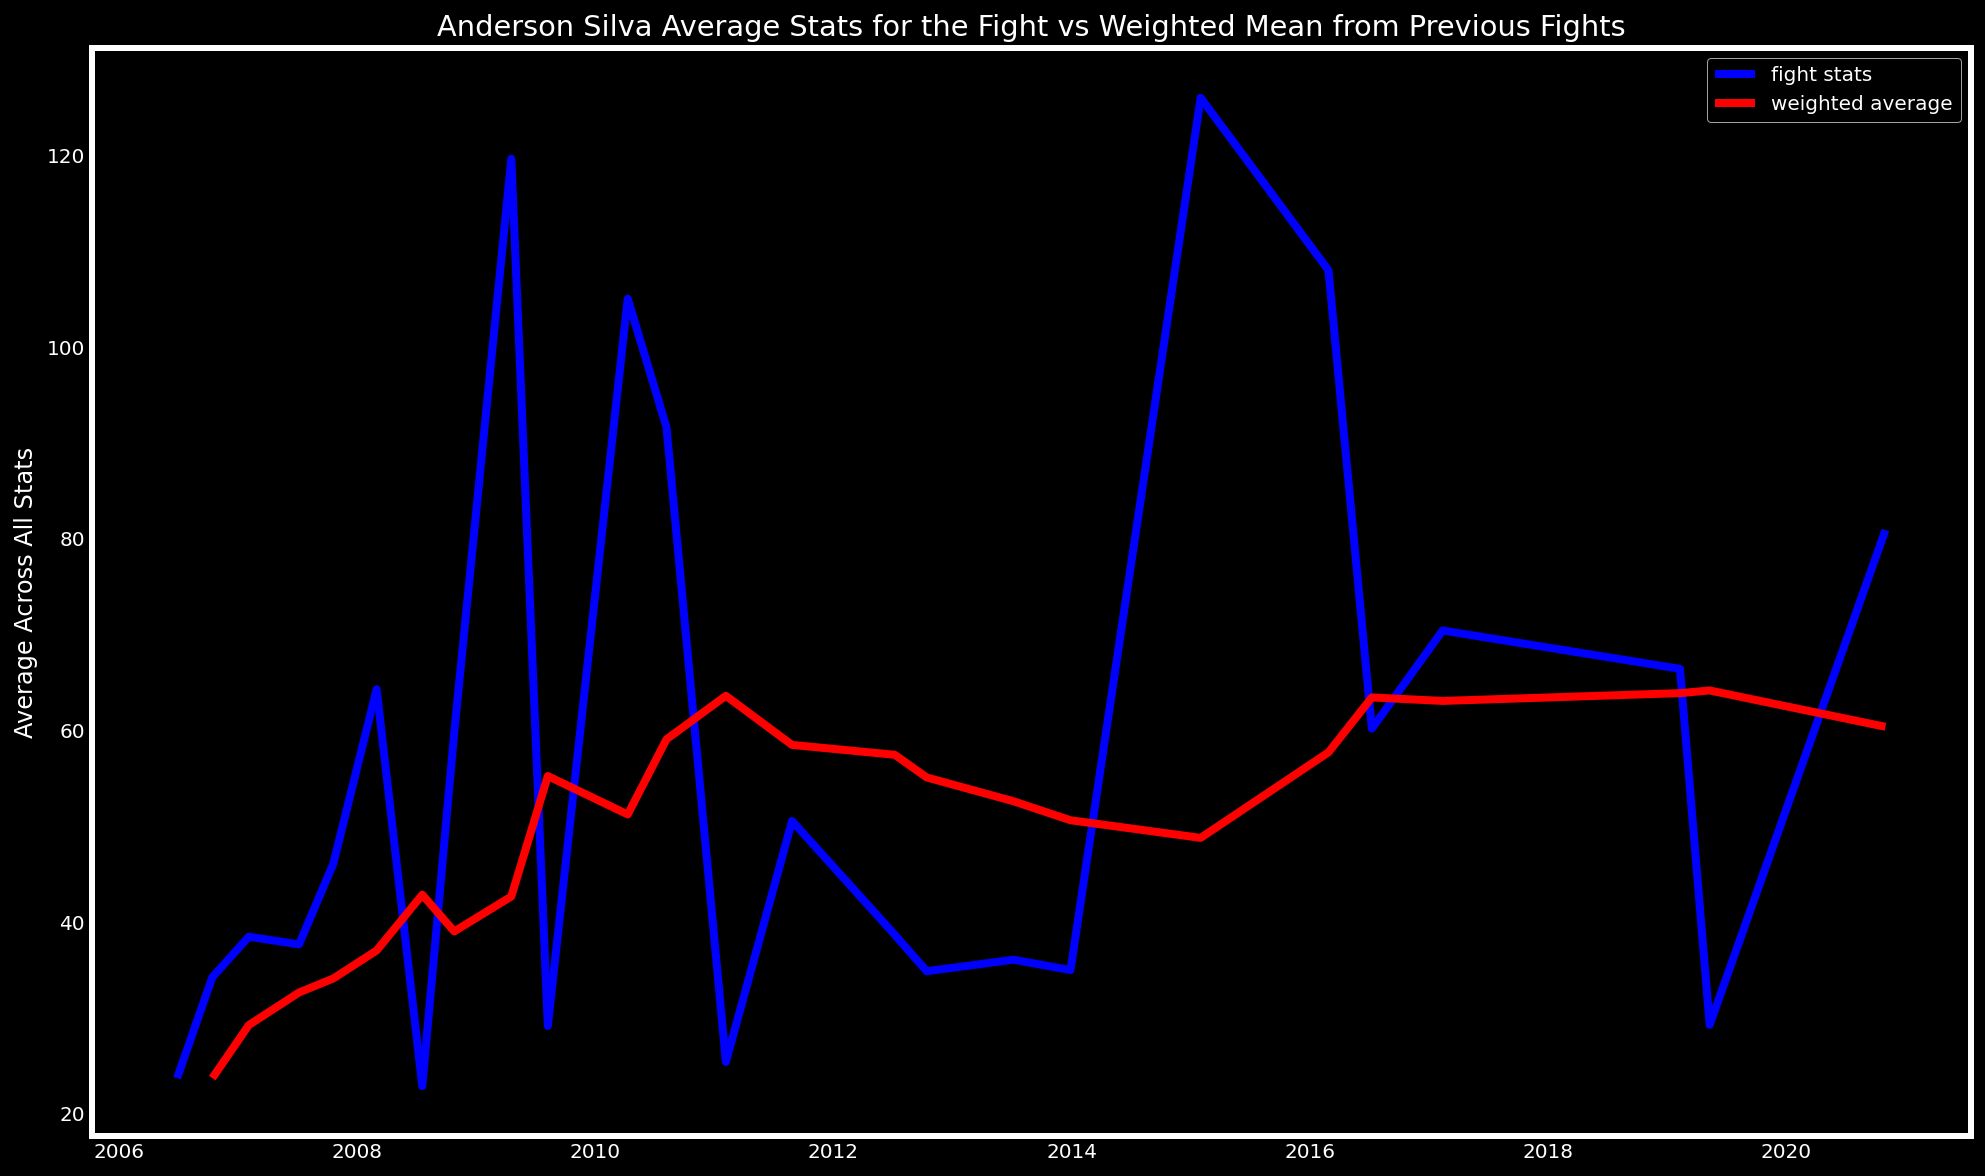

In [464]:

plt.figure(figsize = (15,10))
plt.plot(df_tff[df_tff['fighter'] == 'Anderson Silva' ][avg_cols].mean(axis = 1) ,color = 'blue' , label = 'fight stats')
plt.plot(new_stats[new_stats['fighter'] == 'Anderson Silva' ][avg_cols].mean(axis = 1),color = 'red' , label = 'weighted average' )
plt.title('Anderson Silva Average Stats for the Fight vs Weighted Mean from Previous Fights')
plt.ylabel('Average Across All Stats')
plt.grid(False)
plt.legend()
plt.savefig('AndersonSilva.png', bbox_inches="tight")
plt.show()

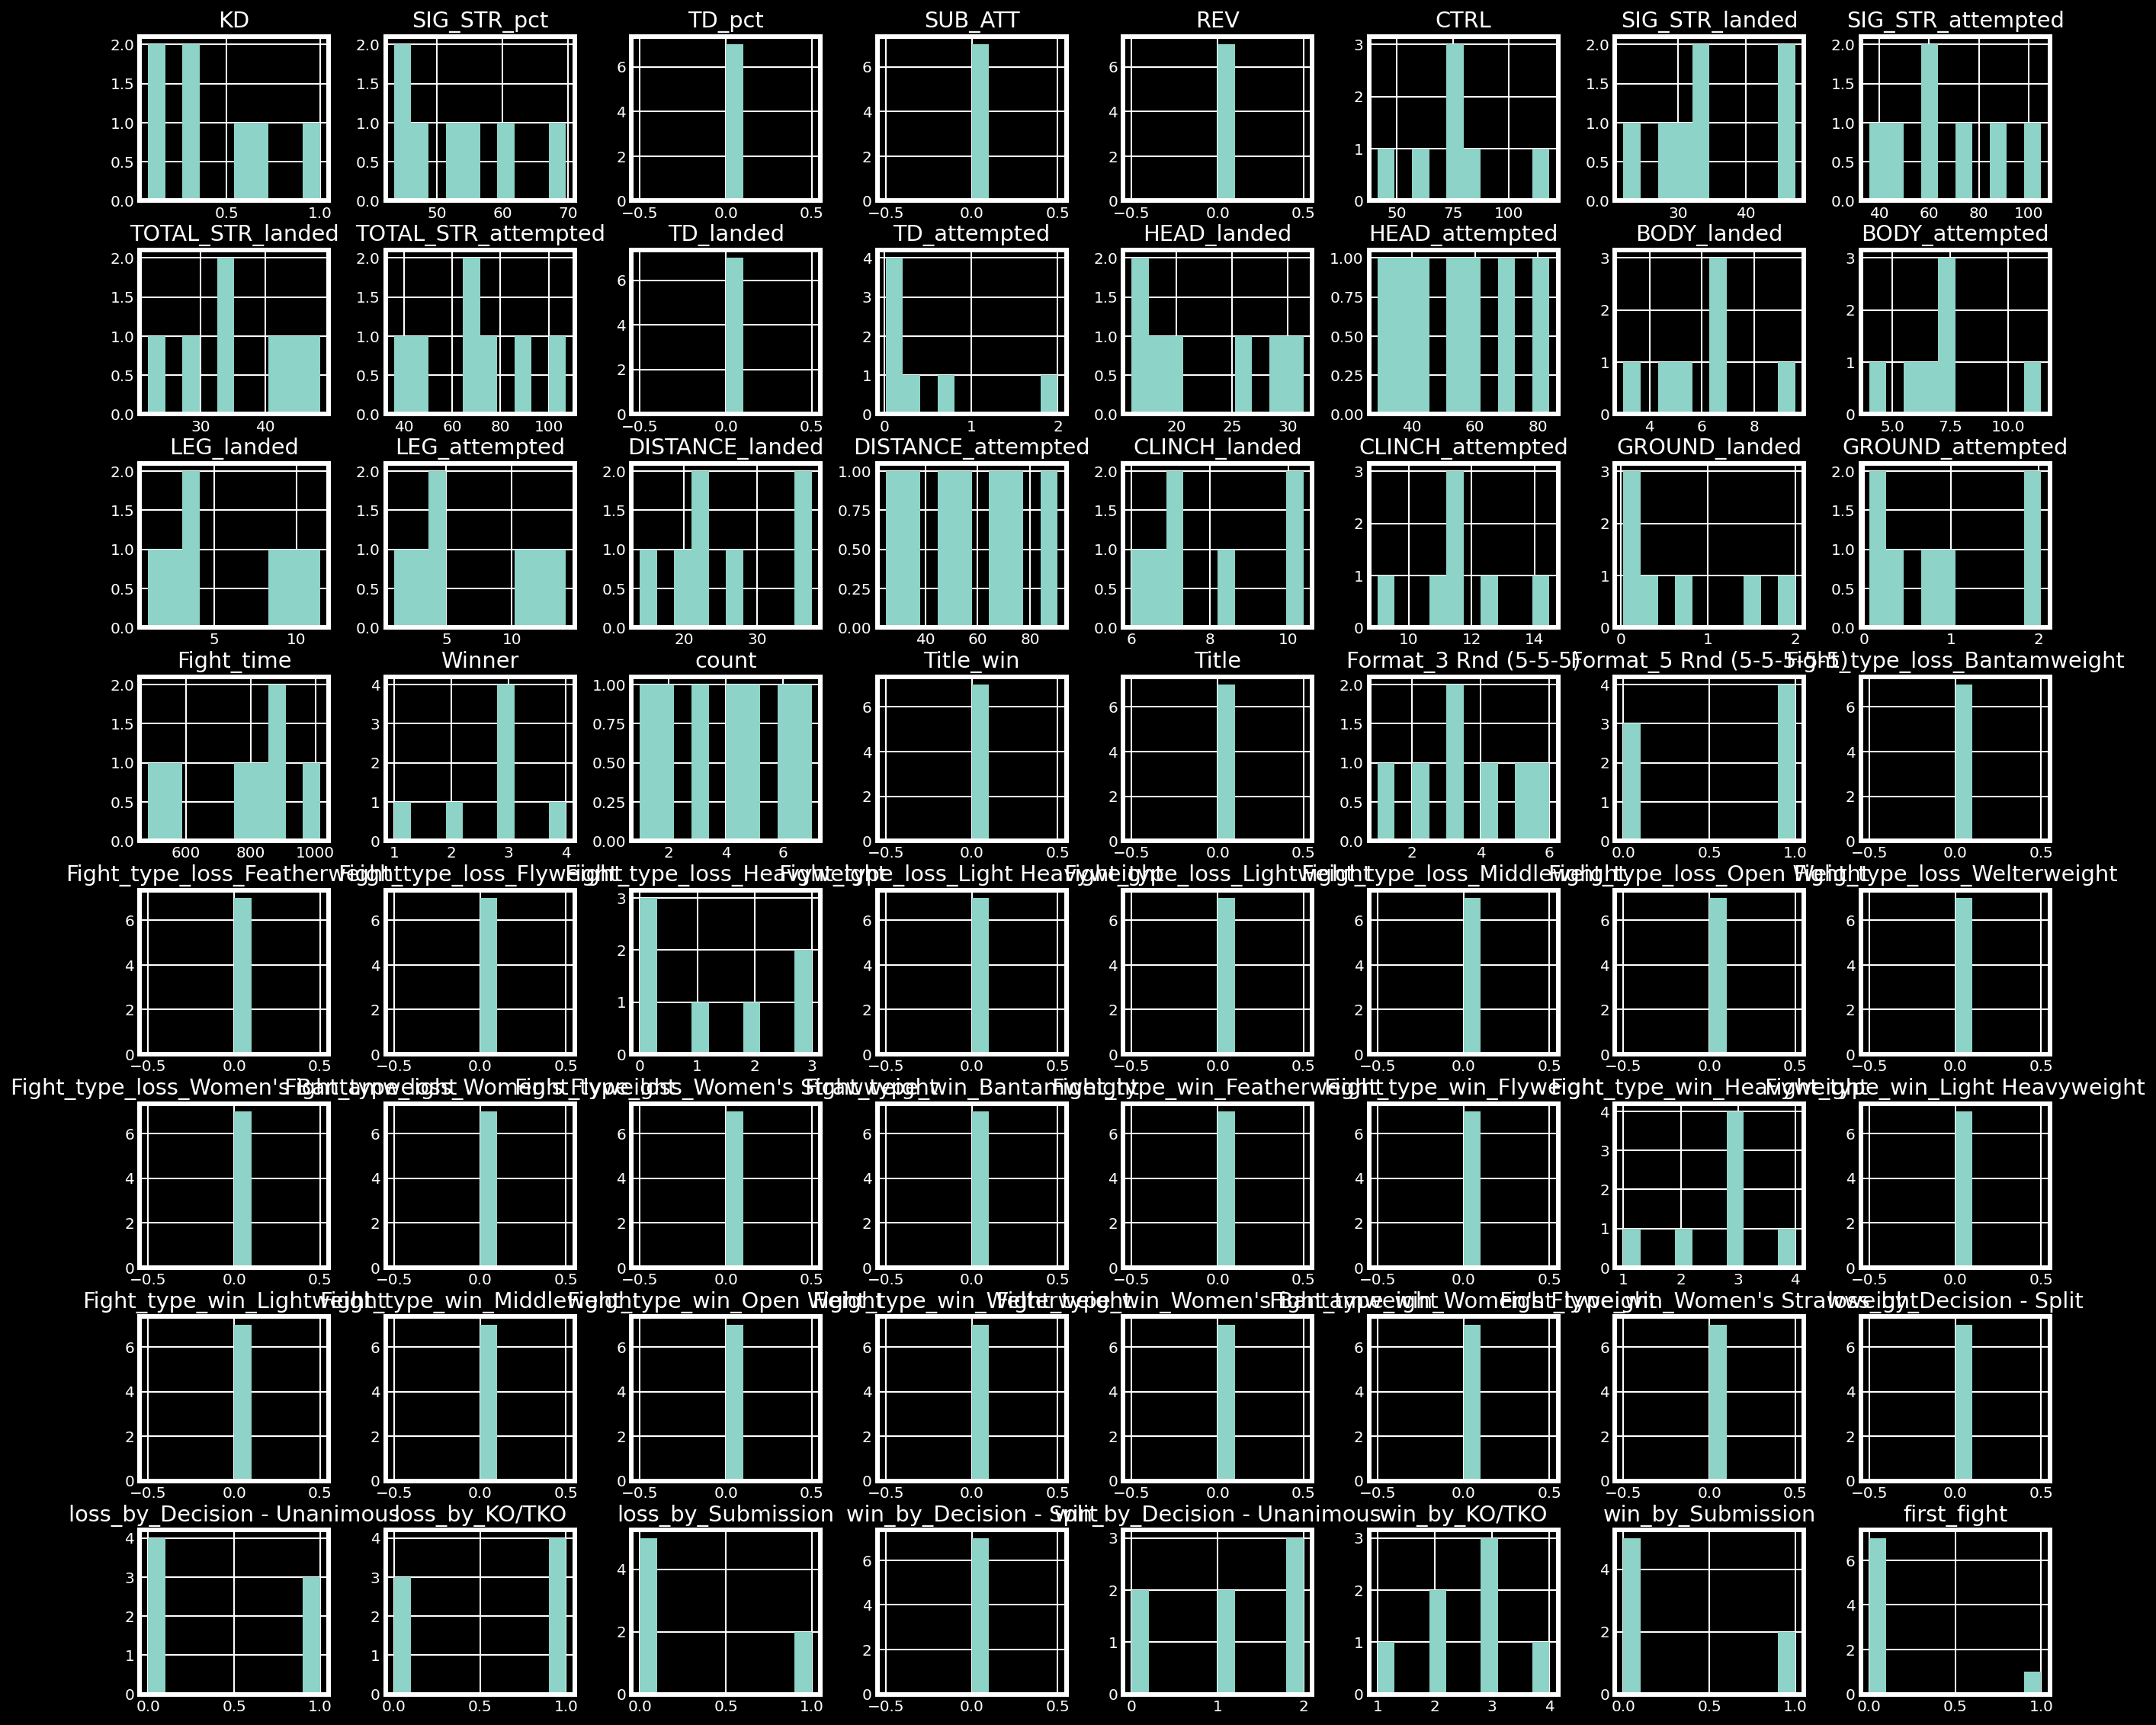

In [234]:
## insight into the distrubution of a single fighter
new_stats[new_stats['fighter'] == 'Tai Tuivasa'].select_dtypes(['number']).hist(figsize=(20,20))
plt.show()

In [56]:
# new_stats = pd.DataFrame()

# for n,info in enumerate(zip(df_tff.fighter, df_tff.date)):
#     #print(info[0], info[1])
#     fight = df_tff[(df_tff['fighter'] == info[0])&(df['date'] < info[1])]
#     fight_avg = fight.groupby('fighter').agg(sumcount['sum'])
#     fight_avg['date'] = info[1]
#     if n == 0:
#         new_stats = fight_avg 
#     else:
#         new_stats = pd.concat([new_stats,fight_avg])

In [378]:
new_stats_edit = new_stats.copy().reset_index()

In [379]:
print(new_stats_edit.shape)

(12024, 66)


In [380]:
## Rename the columns to be more legiable
my_rename_dict = {}
for col in new_stats.columns:
    if any(x in col for x in ['win']):
        my_rename_dict[col] = col.replace('win', 'wins')
    elif any(x in col for x in ['Winner','first_fight']):
        my_rename_dict[col] = col.replace('Winner', 'wins')
    elif any(x in col for x in ['loss']):
        my_rename_dict[col] = col.replace('loss', 'losses')
    elif any(x in col for x in ['Format']):
        my_rename_dict[col] = 'number_of_previous_'+ col
    elif any(x in col for x in ['count']):
        my_rename_dict[col] = col.replace('count', 'number_of_previous_fights')
    elif any(x in col for x in ['fighter','date']):
        pass
    else:
        my_rename_dict[col] = 'average_'+col
    
new_stats_edit.rename(columns = my_rename_dict, inplace = True)

In [462]:
## We don't want to weight the corner as the model may have trouble picking the underdog
## The idea is that it should not matter which corner the fighter is in
## Therefore we shuffle the corner 
df = raw_total_fight_data[['Winner','R_fighter','B_fighter','date','Fight_type']].copy()
df['Fight_type'].replace(weights_mydic, inplace = True )    
df['Title'] = raw_total_fight_data['Fight_type'].apply(lambda x: 1 if 'Title'  in x else 0 )
df = pd.get_dummies(df, columns = ['Fight_type'])
#df 

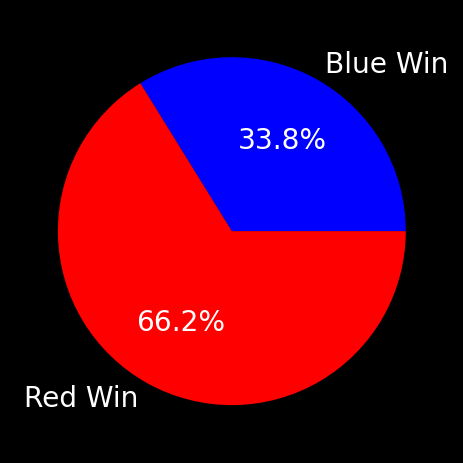

In [463]:
df_pie = df[['Winner','R_fighter','B_fighter']].copy()
df_pie['Winner'] = df_pie.apply(lambda x: 'Red Win' if x['R_fighter'] == x['Winner'] else 'Blue Win' , axis = 1)
df_pie.groupby('Winner').count()['R_fighter'].plot(kind = 'pie',autopct='%1.1f%%', colors = ['blue','red'],fontsize=14)
plt.ylabel('')
plt.savefig('pie.png', bbox_inches="tight")
#df_pie.plot(kind = 'pie', y = 'Winner')

In [447]:


# random indexing, seed for repeatability
# remove seed for randomness
np.random.seed(42)
idx = np.random.rand(len(df)) < 0.5

# passing numpy array to bypass column alignment
df.loc[idx, ['R_fighter','B_fighter']] = df.loc[idx, ['B_fighter','R_fighter']].to_numpy()


In [448]:
## Looking at missing information in the Static stats table

static_stats_ed = static_stats.copy()
static_stats_ed.isnull().sum()

#new_stats_edit[new_stats_edit['first_fight'] == 1]
#missing = static_stats[static_stats_ed.isnull().any(axis=1)]
#missing
#missing.isnull().sum()

fighter_name      0
Height           68
Weight           68
Reach            68
Stance            0
DOB             739
dtype: int64

In [449]:
## Merge the match up back together with the average stats and static stats 

total_merge = df.merge(new_stats_edit, left_on=['R_fighter','date'],right_on = ['fighter','date'], how='inner', indicator=False)
total_merge = total_merge.merge(new_stats_edit, left_on=['B_fighter','date'],right_on = ['fighter','date'], how='inner', indicator=False)
total_merge = total_merge.merge(static_stats, left_on=['R_fighter'],right_on = ['fighter_name'], how='inner', indicator=False)
total_merge = total_merge.merge(static_stats, left_on=['B_fighter'],right_on = ['fighter_name'], how='inner', indicator=False)

In [450]:
## Function to determine the age of each fighter
from datetime import date
def age(birthdate, today ):
    age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
    return age

In [451]:
## Drop the DOB 
total_merge['age_x'] = total_merge.apply(lambda x: age(x.DOB_x , x.date), axis = 1 )
total_merge.drop(columns = ['DOB_x'], inplace = True)
total_merge['age_y'] = total_merge.apply(lambda x: age(x.DOB_y , x.date), axis = 1 )
total_merge.drop(columns = ['DOB_y'], inplace = True)



In [452]:
total_merge['Winner'] = total_merge.apply(lambda x: 1 if x.Winner == x.R_fighter else 0, axis = 1)

In [453]:
ufc = pd.get_dummies(total_merge, columns = ['Stance_y','Stance_x'])

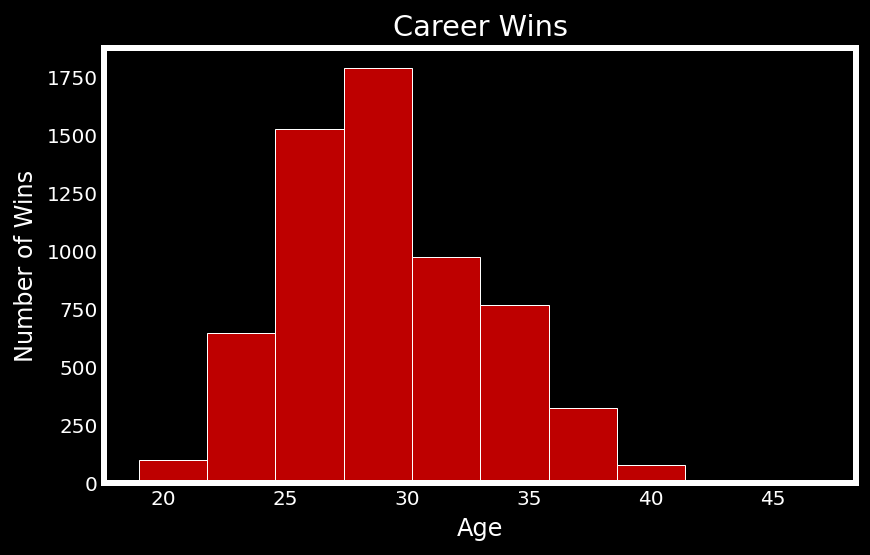

In [454]:
## Wins at each age are represented in this graph, it gives an idea of the peak of a fighters career/ what year they most likely get a win
peak = list(ufc[ufc['Winner'] == 1]['age_x'])+list(ufc[ufc['Winner'] == 0]['age_y'])


sns.histplot(peak, bins = 10, color = 'red' )
plt.ylabel('Number of Wins')
plt.xlabel('Age')
plt.grid(False)
plt.title('Career Wins')
plt.savefig('careerwins.png', bbox_inches="tight")
plt.show()

In [465]:
## A fighter Peak
## looking at the ditrubution of a single fighters tells a slightly different story as the wins are more 
# fighter = 'Anderson Silva'
# fighter_ufc = ufc[(ufc['R_fighter'] == fighter)|(ufc['B_fighter'] == fighter)].sort_values(by = 'date')
# #if fighter_ufc.R_fighter = 
# print(fighter_ufc.columns)
# fighter_ufc.loc[:, (fighter_ufc != 0).any(axis=0)]
# fighter_ufc['fighter_wins'] = fighter_ufc.apply(lambda x:
                                                
#                                                 'Title Win' if ((((x['R_fighter'] == fighter)&(x['Winner'] == 1))|((x['B_fighter'] == fighter) & (x['Winner'] == 0)))&(x['Title'] == 1))
#                                                 else 'Win' if ((x['R_fighter'] == fighter)&(x['Winner'] == 1))|((x['B_fighter'] == fighter) & (x['Winner'] == 0))
#                                                 else 'Tile Loss' if x['Title'] == 1
#                                                 else 'Loss'
#                                                 , axis = 1)
# fighter_ufc['age'] =  fighter_ufc.apply(lambda x: x.age_x if  x['R_fighter'] == fighter else x.age_y, axis = 1 )
# #fighter_ufc['fighter_wins']
# #display(fighter_ufc)
# #sns.histplot(data = fighter_ufc , x =  'age', hue = 'fighter_wins', bins = len(fighter_ufc.date.value_counts()) )


# px.histogram(fighter_ufc, x="", animation_frame="age")

# # peak = list(ufc[(ufc['Winner'] == 1)&ufc['R_fighter'] == fighter ]['age_x'])+list(ufc[(ufc['Winner'] == 0)&(ufc['B_fighter'] == fighter) ]['age_y'])
# # plt.hist(peak)
# # plt.show()

In [ ]:
G_test = nx.Graph()

G_test.add_edges_from([('A', 'B'), ('B', 'C'), ('C', 'D'), ('D', 'A'),
                       ('E', 'F'), ('F', 'G'), ('G', 'H'), ('H', 'E'),
                       ('C', 'E')])
# Second component
pos = nx.drawing.spring_layout(G_test)
nx.draw(G_test, pos=pos, with_labels=True)

In [468]:
ufc_model.columns

Index(['Winner', 'R_fighter', 'B_fighter', 'Title', 'Fight_type_Bantamweight',
       'Fight_type_Featherweight', 'Fight_type_Flyweight',
       'Fight_type_Heavyweight', 'Fight_type_Light Heavyweight',
       'Fight_type_Lightweight',
       ...
       'Stance_y_Open Stance', 'Stance_y_Orthodox', 'Stance_y_Sideways',
       'Stance_y_Southpaw', 'Stance_y_Switch', 'Stance_x_Open Stance',
       'Stance_x_Orthodox', 'Stance_x_Sideways', 'Stance_x_Southpaw',
       'Stance_x_Switch'],
      dtype='object', length=162)

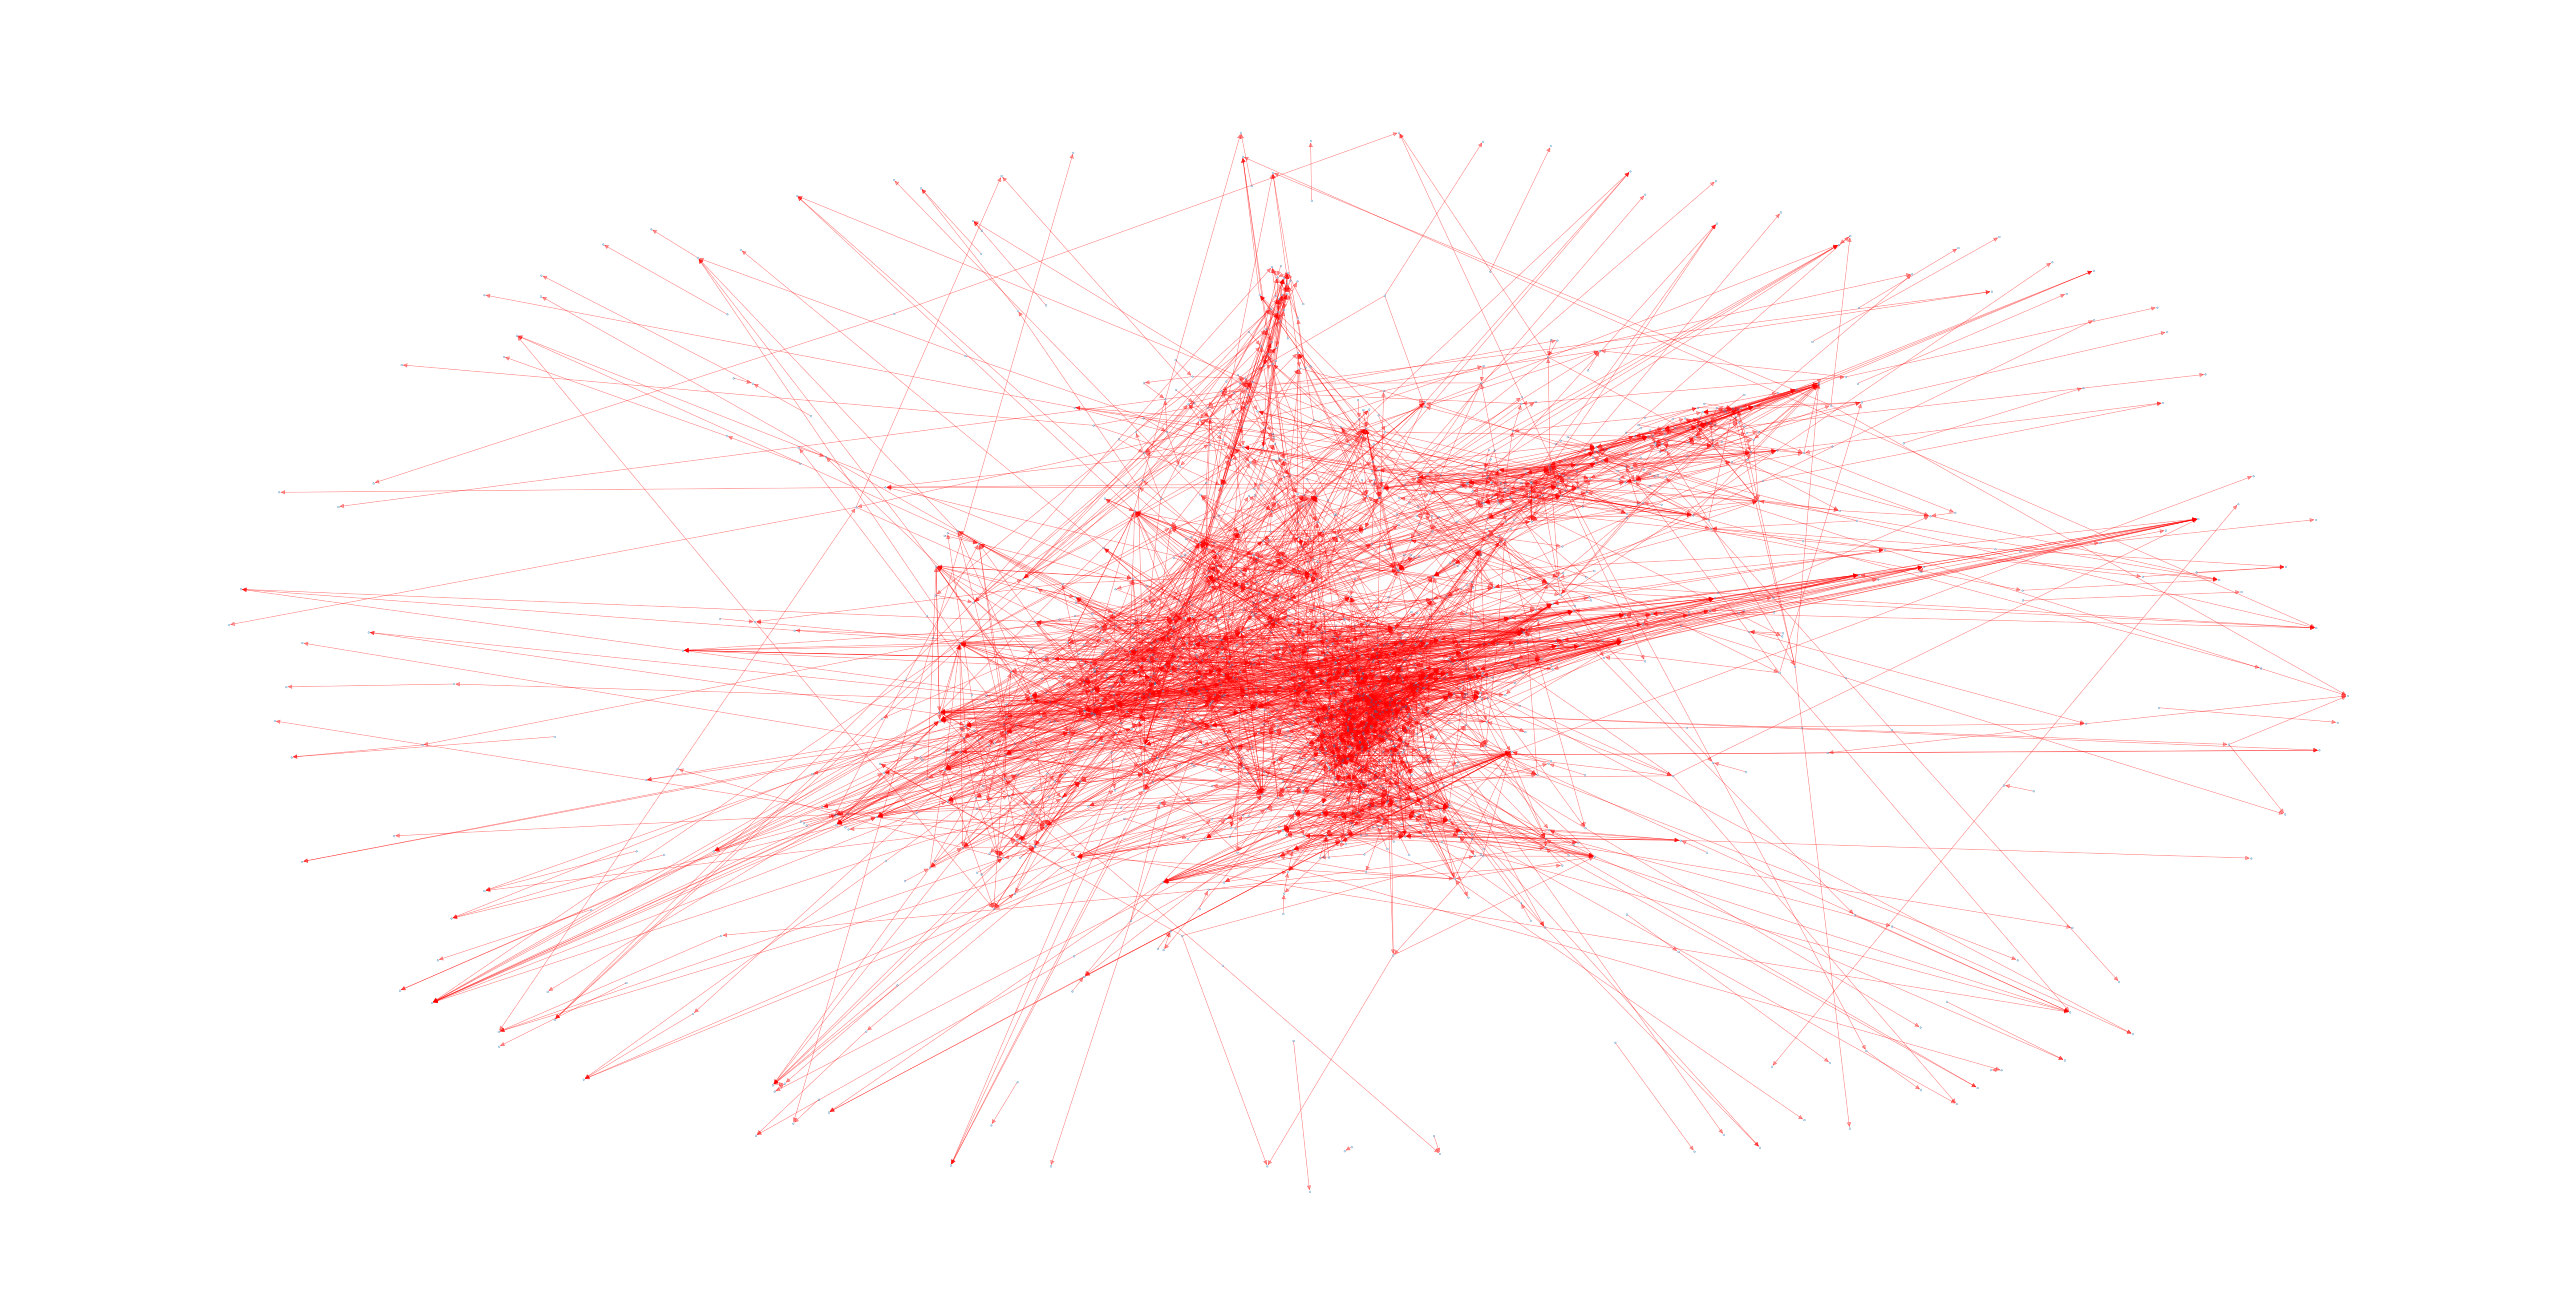

In [497]:
import networkx as nx
import matplotlib.pyplot as plt
 
# ------- DIRECTED
 
# Build a dataframe with your connections
# This time a pair can appear 2 times, in one side or in the other!

net = ufc_model.iloc[:,:3].copy()
net['from'] =  net.apply(lambda x : x['R_fighter'] if x['Winner'] == 0 else x['B_fighter'] , axis = 1 )
net['to'] =  net.apply(lambda x : x['R_fighter'] if x['Winner'] == 1 else x['B_fighter'], axis = 1  )
net.iloc[:,-2:]
# # Build your graph. Note that we use the DiGraph function to create the graph!
G=nx.from_pandas_edgelist(net, 'from', 'to', create_using=nx.DiGraph() )
 
# # Make the graph
plt.figure(figsize = (40,20))
nx.draw_spring(G, with_labels=False, node_size=5, alpha=0.3,edge_color='red', arrows=True)
plt.title("Network of UFC Wins")
plt.savefig('networkmap.png', bbox_inches="tight")
plt.show()

In [ ]:
ufc_model.R_fighter ,ufc_model.B_fighter

nx.draw(G_tube, node_size=20, edge_color=color_labels_tube, edge_cmap=cm.get_cmap('rainbow'), ax=ax[0])

In [ ]:
## add distrubtion of fights with hue of wins and losses

In [455]:
## Dropping the date as the inforamtion is presented as age of the fighter, the actual date of the fight is not important
ufc.drop(columns = ['date','fighter_x','fighter_y','fighter_name_x','fighter_name_y'], inplace = True)

In [456]:
#ufc_model = ufc[avg_cols].fillna(0)
ufc_model = ufc.dropna()

In [458]:
ufc_model.columns

Index(['Winner', 'R_fighter', 'B_fighter', 'Title', 'Fight_type_Bantamweight',
       'Fight_type_Featherweight', 'Fight_type_Flyweight',
       'Fight_type_Heavyweight', 'Fight_type_Light Heavyweight',
       'Fight_type_Lightweight',
       ...
       'Stance_y_Open Stance', 'Stance_y_Orthodox', 'Stance_y_Sideways',
       'Stance_y_Southpaw', 'Stance_y_Switch', 'Stance_x_Open Stance',
       'Stance_x_Orthodox', 'Stance_x_Sideways', 'Stance_x_Southpaw',
       'Stance_x_Switch'],
      dtype='object', length=162)

In [459]:
import pickle

with open("ufc_model", "wb") as fp:   #Pickling
    pickle.dump(ufc_model, fp)

### Network Map of All Fights

In [ ]:
###TBC 